In [1]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [2]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z', 1: 'z'}) -> QuantumCircuit:
    """For E91, we take state to be '00', '01', '10', '11' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(2)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[1] == '1':
        qc.x(1)
    
    # create the superposition
    qc.h(0)
    qc.cx(0,1)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [3]:
print(create_circuit('01',100).draw())

        ┌───┐     ┌────────────────┐ ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├─░─┤M├───
        ├───┤┌─┴─┐├────────────────┤ ░ └╥┘┌─┐
   q_1: ┤ X ├┤ X ├┤ Delay(100[ns]) ├─░──╫─┤M├
        └───┘└───┘└────────────────┘ ░  ║ └╥┘
meas: 2/════════════════════════════════╩══╩═
                                        0  1 


In [4]:
print(create_circuit('00',100,{0: 'z', 1: 'x'}).draw())

        ┌───┐     ┌────────────────┐      ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Delay(100[ns]) ├──────░─┤M├───
        └───┘┌─┴─┐├────────────────┤┌───┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├┤ Delay(100[ns]) ├┤ H ├─░──╫─┤M├
             └───┘└────────────────┘└───┘ ░  ║ └╥┘
meas: 2/═════════════════════════════════════╩══╩═
                                             0  1 


In [5]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int,
               q2_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","sdg","id"])
        
        q2_len = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q2_gate_len)
        thermal_gate_2q = q2_len.tensor(q2_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_2q,"cx")
    
    return noise_model

In [6]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['measure', 'sdg', 'h', 'id', 'delay', 'cx', 'x']>

In [7]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['measure', 'delay']>

In [8]:
noise_params = {"T1":93400, "T2":116160} # ibmq_lima
q1_gate_len = 35.55 # 3.5555555555555554e-08
q2_gate_len = 305.77 # ibmq_lima
measure_len = 5351.11 # ibmq_lima

In [58]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for E91 protocol"""
    """Channel: 1 => |00>+|11>, 2 => |01>+|10>"""
    
    if channel == '1':
        state = '00'
    elif channel == '2':
        state = '01'
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,q2_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    
    success11=0
    success00=0
    success01=0
    success10=0
    
    
    if channel == '1':
        if '00' in counts.keys():
            success00 += counts['00']
        if '11' in counts.keys():
            success11 += counts['11']
        if '10' in counts.keys():
            success10 += counts['10']
        if '01' in counts.keys():
            success01 += counts['01']
    
    elif channel == '2':
        if '00' in counts.keys():
            success00 += counts['00']
        if '11' in counts.keys():
            success11 += counts['11']
        if '10' in counts.keys():
            success10 += counts['10']
        if '01' in counts.keys():
            success01 += counts['01']
    return float(success00/shots),float(success11/shots),float(success10/shots),float(success01/shots)

In [59]:
run('1',1000,{"delay": True, "measure": False, "gate": False})

(0.5, 0.488, 0.008, 0.004)

In [60]:
run('1',1000,{"delay": True, "measure": True, "gate": False})

(0.502, 0.425, 0.038, 0.035)

In [61]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

(0.517, 0.42, 0.035, 0.028)

# Only Delay

# |00>+|11>

In [62]:
import matplotlib.pyplot as plt
success_state00=[]
success_state11=[]
success_state01=[]
success_state10=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '1'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success11=[]
    success00=[]
    success01=[]
    success10=[]
    
    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success00.append(prob[0])
        success11.append(prob[1])
        success10.append(prob[2])
        success01.append(prob[3])
    success_state00.append(success00)
    success_state11.append(success11)
    success_state01.append(success01)
    success_state10.append(success10) 

In [63]:
import numpy as np
delay = np.arange(0,1001000,1000)


In [64]:
from statistics import mean
a= success_state00
print(*map(mean, zip(*a)))

0.50315 0.49855 0.49775 0.50175 0.50065 0.4975 0.4958 0.50045 0.5035000000000001 0.50185 0.5105500000000001 0.5071 0.50585 0.51225 0.5075000000000001 0.51585 0.51505 0.5153 0.5182 0.5144 0.51875 0.5157 0.5151 0.5208 0.5261 0.5231 0.53185 0.53635 0.5339 0.53545 0.53485 0.5317000000000001 0.5457500000000001 0.548 0.5524 0.55325 0.55305 0.5517 0.56 0.56125 0.5644 0.56325 0.5637 0.56295 0.5707 0.5742499999999999 0.57505 0.57545 0.5801999999999999 0.5852999999999999 0.5854999999999999 0.5837 0.5932999999999999 0.58795 0.5968 0.5973499999999999 0.60265 0.6006 0.60095 0.6049 0.61125 0.6136 0.6183 0.61965 0.6234999999999999 0.62295 0.6291 0.62195 0.63845 0.636 0.63805 0.64505 0.6421 0.6472 0.64895 0.65315 0.65645 0.6593 0.6622 0.66145 0.66725 0.66735 0.67125 0.67395 0.6767 0.6745 0.67655 0.68735 0.68935 0.69075 0.69285 0.69145 0.7007 0.701 0.707 0.70195 0.7054 0.70875 0.71005 0.7097 0.71755 0.7155 0.72045 0.71925 0.7197 0.7286 0.7248 0.73385 0.7297 0.7368 0.743 0.7419 0.74205 0.7471 0.75165 0.

In [65]:
from statistics import mean
a= success_state11
print(*map(mean, zip(*a)))

0.49685 0.491 0.48145 0.4667 0.4602 0.4537 0.4444 0.4305 0.4222 0.4172 0.3991 0.39125 0.3872 0.3754 0.37305 0.35495 0.3538 0.35005 0.3402 0.3366 0.32695 0.31915 0.3139 0.30795 0.2986 0.28895 0.2887 0.27655 0.27105 0.26845 0.26225 0.2603 0.2502 0.24425 0.24205 0.2327 0.2305 0.22895 0.2208 0.21805 0.2101 0.21085 0.20205 0.19705 0.193 0.1912 0.19055 0.1842 0.1787 0.17275 0.17295 0.16955 0.1597 0.15935 0.15685 0.15495 0.1548 0.14785 0.14629999999999999 0.1441 0.14155 0.13385 0.12875 0.1289 0.12755 0.12665 0.121 0.1234 0.11660000000000001 0.1186 0.1099 0.1074 0.1058 0.1032 0.10585 0.1007 0.0983 0.09395 0.0925 0.09635 0.0898 0.0876 0.0806 0.08355 0.0882 0.08165 0.0821 0.0781 0.0771 0.0735 0.0728 0.0708 0.0688 0.06555 0.0646 0.065 0.06445000000000001 0.06465 0.06115 0.060200000000000004 0.05495 0.05775 0.05565 0.0534 0.0585 0.0549 0.05315 0.051 0.05355 0.0477 0.04825 0.0494 0.04705 0.044 0.04155 0.04225 0.0408 0.0423 0.04005 0.03825 0.0363 0.0354 0.03855 0.0352 0.03695 0.03465 0.0319 0.03175 

In [66]:
from statistics import mean
a= success_state01
print(*map(mean, zip(*a)))

0.0 0.0051 0.011 0.0174 0.01995 0.024 0.03045 0.03425 0.0363 0.04055 0.04635 0.05155 0.0538 0.0553 0.06155 0.0656 0.06505 0.0672 0.07115 0.0731 0.07615 0.0817 0.08655 0.0837 0.08755 0.09575 0.0908 0.08889999999999999 0.09635 0.09735 0.10205 0.1071 0.10145 0.1059 0.10305 0.10785 0.10775 0.10665 0.10805000000000001 0.1122 0.1121 0.11385 0.11695 0.12205 0.1207 0.11525 0.1171 0.1223 0.11875 0.11995 0.11935 0.12445 0.1261 0.12505 0.12325 0.1237 0.12135 0.12265000000000001 0.1262 0.12365 0.12235 0.1263 0.1295 0.12365 0.12325 0.128 0.1251 0.1261 0.12135 0.1205 0.1259 0.12365 0.12615 0.1243 0.12075 0.1231 0.122 0.1223 0.12245 0.11995 0.1222 0.12415 0.12355 0.1216 0.1186 0.1235 0.1235 0.1183 0.1161 0.11695 0.1196 0.12145 0.11475 0.1155 0.11205 0.11455 0.1147 0.11375 0.11745 0.11695 0.112 0.11245 0.11285 0.1157 0.1097 0.10805000000000001 0.1096 0.10615 0.1108 0.10765 0.1021 0.10435 0.10435 0.1062 0.10355 0.1019 0.1025 0.10095 0.1004 0.1061 0.0983 0.09825 0.09965 0.0965 0.098 0.0986 0.0975 0.0968

In [67]:
from statistics import mean
a= success_state10
print(*map(mean, zip(*a)))

0.0 0.00535 0.0098 0.01415 0.019200000000000002 0.0248 0.02935 0.0348 0.038 0.0404 0.044 0.0501 0.05315 0.057050000000000003 0.0579 0.0636 0.0661 0.06745 0.07045 0.0759 0.07815 0.08345 0.08445 0.08755 0.08775 0.0922 0.08865 0.0982 0.0987 0.09875 0.10085 0.1009 0.1026 0.10185 0.1025 0.1062 0.1087 0.1127 0.11115 0.1085 0.1134 0.11205 0.1173 0.11795 0.1156 0.1193 0.1173 0.11805 0.12235 0.122 0.1222 0.12229999999999999 0.12090000000000001 0.12765 0.1231 0.124 0.1212 0.12890000000000001 0.12655 0.12735 0.12485 0.12625 0.12345 0.1278 0.1257 0.1224 0.1248 0.12855 0.1236 0.1249 0.12615 0.1239 0.12595 0.1253 0.12445 0.12305 0.12325 0.12445 0.12285 0.12225 0.12075 0.12090000000000001 0.1246 0.12090000000000001 0.1165 0.12035 0.11785 0.11625 0.11745 0.1188 0.11475 0.1163 0.11575 0.11795 0.11635 0.11850000000000001 0.11545 0.11285 0.11135 0.11315 0.1155 0.1143 0.11105 0.11165 0.1121 0.10845 0.11245 0.109 0.10595 0.10785 0.10665 0.10435 0.10655 0.1027 0.10325 0.10205 0.1051 0.09805 0.101 0.099 0.10

In [71]:
# 20 Times Average 
d00=[0.50315,0.49855,0.49775,0.50175,0.50065,0.4975,0.4958,0.50045,0.5035000000000001,0.50185,0.5105500000000001,0.5071,0.50585,0.51225,0.5075000000000001,0.51585,0.51505,0.5153,0.5182,0.5144,0.51875,0.5157,0.5151,0.5208,0.5261,0.5231,0.53185,0.53635,0.5339,0.53545,0.53485,0.5317000000000001,0.5457500000000001,0.548,0.5524,0.55325,0.55305,0.5517,0.56,0.56125,0.5644,0.56325,0.5637,0.56295,0.5707,0.5742499999999999,0.57505,0.57545,0.5801999999999999,0.5852999999999999,0.5854999999999999,0.5837,0.5932999999999999,0.58795,0.5968,0.5973499999999999,0.60265,0.6006,0.60095,0.6049,0.61125,0.6136,0.6183,0.61965,0.6234999999999999,0.62295,0.6291,0.62195,0.63845,0.636,0.63805,0.64505,0.6421,0.6472,0.64895,0.65315,0.65645,0.6593,0.6622,0.66145,0.66725,0.66735,0.67125,0.67395,0.6767,0.6745,0.67655,0.68735,0.68935,0.69075,0.69285,0.69145,0.7007,0.701,0.707,0.70195,0.7054,0.70875,0.71005,0.7097,0.71755,0.7155,0.72045,0.71925,0.7197,0.7286,0.7248,0.73385,0.7297,0.7368,0.743,0.7419,0.74205,0.7471,0.75165,0.7538,0.7516,0.7587,0.7585500000000001,0.75665,0.7648,0.7645500000000001,0.76605,0.77195,0.7724,0.77075,0.7772,0.7765500000000001,0.77885,0.77815,0.7867000000000001,0.7891,0.77945,0.78945,0.7902,0.7969,0.799,0.7938500000000001,0.7975,0.79505,0.80835,0.8001,0.80355,0.803,0.8063,0.807,0.80985,0.80775,0.8173,0.81415,0.81535,0.8227,0.8241999999999999,0.8236,0.82875,0.82655,0.8293499999999999,0.8304499999999999,0.8333999999999999,0.84095,0.8369,0.838,0.8396,0.8432,0.84115,0.84725,0.8456,0.85115,0.8523499999999999,0.84655,0.8509,0.85725,0.8554499999999999,0.8528,0.85885,0.85585,0.857,0.8659,0.8613,0.86295,0.86455,0.86565,0.8613,0.8694999999999999,0.8714,0.86905,0.87295,0.87725,0.8738,0.87775,0.876,0.87835,0.87935,0.87965,0.8845000000000001,0.8858,0.8847,0.88545,0.8887,0.8867,0.88945,0.88625,0.8966000000000001,0.892,0.8924,0.8934,0.89685,0.8956000000000001,0.8975,0.8998,0.89735,0.90135,0.9022,0.90445,0.9055,0.90525,0.90415,0.9069,0.9107000000000001,0.90345,0.9111,0.9116500000000001,0.9123,0.91335,0.9123,0.9147500000000001,0.91415,0.91715,0.9158000000000001,0.9181,0.9196500000000001,0.91825,0.92,0.9212,0.9216000000000001,0.9262,0.92,0.92635,0.9267000000000001,0.92725,0.9256500000000001,0.93125,0.9265,0.9309000000000001,0.9264,0.928,0.92995,0.9305,0.93355,0.9329500000000001,0.93355,0.932,0.93465,0.9355,0.93725,0.9389,0.9383,0.93825,0.93725,0.9448,0.9398,0.9415,0.9421499999999999,0.94125,0.9444,0.9448,0.94355,0.94245,0.9457,0.9459,0.9493499999999999,0.94665,0.949,0.9452499999999999,0.94835,0.95095,0.9499,0.9490999999999999,0.9501999999999999,0.9512999999999999,0.9511499999999999,0.9527,0.9531,0.95205,0.95205,0.95265,0.9555,0.95605,0.95485,0.9541,0.9586,0.9572999999999999,0.9562999999999999,0.9553999999999999,0.95665,0.9581,0.9597,0.9583499999999999,0.9592499999999999,0.9611,0.95995,0.9603999999999999,0.96175,0.96265,0.96315,0.96285,0.9623499999999999,0.9616,0.9658,0.9657,0.9639,0.9637,0.9642999999999999,0.96665,0.96775,0.9678,0.9682999999999999,0.9684999999999999,0.9642999999999999,0.96615,0.9694499999999999,0.968,0.9694499999999999,0.96955,0.9692999999999999,0.9698,0.96785,0.971,0.97055,0.9714499999999999,0.97205,0.9719,0.9723499999999999,0.96985,0.9732,0.971,0.9715,0.973,0.97385,0.9736,0.97265,0.97375,0.9751,0.97455,0.97725,0.97655,0.9766,0.9764499999999999,0.97625,0.9757,0.9783,0.97675,0.9769,0.9783999999999999,0.9763499999999999,0.97765,0.9781,0.97805,0.97865,0.9791,0.9795,0.9802,0.9797,0.97985,0.9783499999999999,0.9793999999999999,0.9788,0.98015,0.9809,0.98165,0.981,0.9809,0.98275,0.9809,0.9804999999999999,0.982,0.98305,0.98155,0.98335,0.9821,0.98285,0.9813999999999999,0.9822,0.98595,0.9854499999999999,0.98375,0.98275,0.98485,0.9843999999999999,0.9846,0.9844999999999999,0.9846,0.9846,0.98675,0.9843,0.98625,0.98635,0.9862,0.9875,0.9862,0.98515,0.9864499999999999,0.9852,0.98695,0.98735,0.98665,0.9882,0.98705,0.9875,0.9877,0.9877,0.9889,0.98875,0.98685,0.9879,0.9884,0.98765,0.98915,0.9889,0.98965,0.98935,0.9892,0.9888,0.98855,0.98935,0.98905,0.98825,0.9897,0.98875,0.9897,0.98925,0.98975,0.98885,0.9892,0.99005,0.9898,0.9902,0.9904999999999999,0.99165,0.9914499999999999,0.99035,0.99185,0.9908,0.9913,0.99255,0.9915,0.99255,0.9915,0.99255,0.99175,0.99135,0.9913,0.9904,0.9919,0.99305,0.9918,0.9924499999999999,0.99115,0.99355,0.9923,0.99255,0.99265,0.99275,0.99295,0.99395,0.99325,0.9937,0.9922,0.9931,0.99335,0.993,0.9938,0.9927,0.9934499999999999,0.9935,0.994,0.9933,0.99375,0.9935,0.99435,0.9943,0.9948,0.99495,0.995,0.9944,0.9942,0.99485,0.9947,0.99405,0.9944999999999999,0.9949,0.99435,0.9947,0.995,0.9948,0.9949,0.995,0.9946,0.9946,0.9948,0.9946,0.99445,0.995,0.9954,0.995,0.9955,0.9951,0.9953,0.9947,0.9955,0.996,0.9958,0.99665,0.996,0.996,0.99565,0.9964999999999999,0.9968,0.9973,0.9958,0.99605,0.99645,0.99525,0.9964999999999999,0.9958,0.99595,0.9964,0.99645,0.99635,0.99625,0.997,0.9962,0.99705,0.99605,0.99645,0.99625,0.9966,0.99755,0.9964,0.99665,0.99715,0.99665,0.9969,0.99735,0.997,0.9971,0.9964,0.9969,0.9978,0.9975,0.99695,0.99765,0.9976,0.9972,0.99725,0.99695,0.9974,0.9977,0.99765,0.9975,0.99785,0.99765,0.99785,0.9975,0.9971,0.99775,0.99805,0.99755,0.99805,0.99795,0.9973,0.9981,0.9977,0.99775,0.997,0.9983,0.9979,0.99815,0.9981,0.9979,0.99735,0.998,0.9984,0.99815,0.99795,0.998,0.9978,0.9981,0.9984999999999999,0.9984999999999999,0.99775,0.99825,0.99855,0.998,0.99865,0.99865,0.99855,0.99875,0.9983,0.9984,0.99845,0.99835,0.9986,0.9984999999999999,0.99835,0.99825,0.9982,0.99805,0.99865,0.9988,0.99815,0.9986,0.9982,0.9993,0.99895,0.99895,0.9984,0.9983,0.99855,0.99835,0.99895,0.99875,0.9986,0.999,0.99905,0.99845,0.99865,0.99855,0.99885,0.9988,0.9984999999999999,0.99865,0.99895,0.99875,0.99875,0.99885,0.99875,0.99915,0.99855,0.9989,0.99895,0.9989,0.9986,0.99915,0.99895,0.9989,0.99915,0.99905,0.9988,0.9992,0.9989,0.99895,0.99915,0.9989,0.9991,0.99925,0.99895,0.9987,0.99895,0.99925,0.999,0.999,0.999,0.99885,0.9991,0.99925,0.9993,0.9994,0.9992,0.9993,0.9993,0.9991,0.99905,0.9993,0.9994,0.99945,0.99945,0.99935,0.99955,0.9992,0.99925,0.9994,0.99925,0.99935,0.99945,0.99945,0.99945,0.9991,0.99945,0.9994,0.99945,0.9995,0.99935,0.9994,0.9996,0.9991,0.99915,0.9993,0.9993,0.999,0.9996,0.99965,0.9992,0.99945,0.9996,0.99975,0.9996,0.99965,0.9992,0.99965,0.99955,0.9997,0.9993,0.99945,0.99945,0.9996,0.99945,0.99955,0.99975,0.99945,0.9994,0.9996,0.9998,0.99955,0.9994,0.99955,0.99955,0.9997,0.9995,0.9996,0.9997,0.99965,0.9997,0.9993,0.99965,0.99985,0.99955,0.99945,0.9994,0.99975,0.99985,0.99975,0.99945,0.9997,0.9997,0.9995,0.9999,0.99965,0.99965,0.9996,0.9996,0.9996,0.99975,0.99965,0.99975,0.99985,0.99965,0.9996,0.99965,0.99975,0.9999,0.9998,0.9998,0.9999,0.9997,0.99965,0.9996,0.9997,0.9996,0.9996,0.9998,0.9998,0.99995,0.9997,0.9997,0.9998,0.99965,0.99995,0.99965,0.99965,0.99965,0.99965,0.9999,0.99965,0.9997,0.9997,0.9997,1.0,0.9998,0.99995,0.9998,0.99985,0.99975,0.9998,0.99975,0.9998,0.9997,0.9998,0.99995,0.99975,0.9998,0.99985,0.9997,0.99985,0.99985,0.9999,0.9999,0.99985,0.99995,0.99985,0.99975,0.9998,0.9998,0.9998,0.9999,1.0,0.9998,0.9999,0.9999,0.9999,0.99985,0.9997,0.99985,0.9999,0.9999,0.9999,0.9998,0.9998,0.99985,0.99985,0.9998,0.9999,0.99985,1.0,0.9999,0.9998,0.9999,0.99995,0.99985,1.0,0.99995,0.99995,0.99995,0.99985,0.9998,0.99965,0.9999,0.9999,0.99995,0.99995,0.9999,0.99985,0.9999,0.99995,0.9998,0.9998,0.9999,0.99995,0.9999,0.9999,0.9999,0.99995,0.9999,0.99995,1.0,0.99975,1.0,0.99985,0.9999,0.99995,0.9999,0.99995,0.99995,1.0,0.9999,1.0,0.9999,0.9999,0.99995,0.9999,0.99995,0.9999,0.9999,0.99995,0.9999,0.9999,0.99985,0.99995,0.99975,0.99985,0.99995,0.99995,1.0,0.99995,0.99975,0.9999,0.99985,0.99995,1.0,1.0,0.99995,0.9999,0.99995,1.0,0.9999,0.99995,0.99995,0.9999,1.0,1.0,0.99995,0.9999,0.9999,0.9999,1.0,0.9999,0.9999,0.99975,1.0,1.0,0.9999,0.99995,0.99995,0.99985,0.99995,1.0,0.99995,1.0,0.9999,1.0,1.0,0.99985,0.99995,0.99995,0.99995,0.99985,0.99995,1.0,0.99995,0.99995,0.9999,0.9999,0.99995,1.0,0.99995,0.99995,1.0,1.0,1.0,0.99995,0.99995,0.99995,0.9999,0.99995,0.9999,0.99995,0.9999,1.0,1.0,0.9999,0.99995,0.99995,0.99995,0.99995,1.0,0.99995,1.0,0.9999,1.0,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,1.0,0.99995,1.0,0.99995,1.0,0.99995,0.99995,0.99995,1.0,0.99995,1.0,0.99995,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,0.99995,1.0,1.0,0.99995,1.0,1.0]


In [72]:
d11=[0.49685,0.491,0.48145,0.4667,0.4602,0.4537,0.4444,0.4305,0.4222,0.4172,0.3991,0.39125,0.3872,0.3754,0.37305,0.35495,0.3538,0.35005,0.3402,0.3366,0.32695,0.31915,0.3139,0.30795,0.2986,0.28895,0.2887,0.27655,0.27105,0.26845,0.26225,0.2603,0.2502,0.24425,0.24205,0.2327,0.2305,0.22895,0.2208,0.21805,0.2101,0.21085,0.20205,0.19705,0.193,0.1912,0.19055,0.1842,0.1787,0.17275,0.17295,0.16955,0.1597,0.15935,0.15685,0.15495,0.1548,0.14785,0.14629999999999999,0.1441,0.14155,0.13385,0.12875,0.1289,0.12755,0.12665,0.121,0.1234,0.11660000000000001,0.1186,0.1099,0.1074,0.1058,0.1032,0.10585,0.1007,0.0983,0.09395,0.0925,0.09635,0.0898,0.0876,0.0806,0.08355,0.0882,0.08165,0.0821,0.0781,0.0771,0.0735,0.0728,0.0708,0.0688,0.06555,0.0646,0.065,0.06445000000000001,0.06465,0.06115,0.060200000000000004,0.05495,0.05775,0.05565,0.0534,0.0585,0.0549,0.05315,0.051,0.05355,0.0477,0.04825,0.0494,0.04705,0.044,0.04155,0.04225,0.0408,0.0423,0.04005,0.03825,0.0363,0.0354,0.03855,0.0352,0.03695,0.03465,0.0319,0.03175,0.0323,0.0318,0.028900000000000002,0.03015,0.03085,0.02875,0.0275,0.02785,0.0283,0.02605,0.02615,0.0249,0.025750000000000002,0.0239,0.023,0.02445,0.0236,0.02225,0.022350000000000002,0.02205,0.0211,0.0195,0.0194,0.01925,0.017499999999999998,0.018349999999999998,0.01875,0.0172,0.0175,0.0168,0.016900000000000002,0.01625,0.016,0.016300000000000002,0.0179,0.0156,0.01475,0.0143,0.0133,0.0139,0.014199999999999999,0.01455,0.013049999999999999,0.0133,0.013349999999999999,0.01225,0.01205,0.01175,0.01145,0.01045,0.0111,0.01185,0.0103,0.0085,0.0109,0.0111,0.01045,0.0095,0.012199999999999999,0.00755,0.0088,0.0088,0.0081,0.00825,0.00765,0.00865,0.0079,0.0079,0.0069500000000000004,0.00895,0.0065,0.0074,0.00775,0.00705,0.00785,0.006500000000000001,0.007,0.0064,0.00655,0.0062,0.0063,0.00585,0.00535,0.006,0.00525,0.00465,0.00635,0.0046500000000000005,0.0053,0.00495,0.00545,0.0042,0.00415,0.0044,0.00405,0.0044,0.00455,0.0046,0.0039000000000000003,0.00255,0.00445,0.00365,0.00315,0.004,0.0032,0.00255,0.0025,0.00295,0.00395,0.0032,0.00305,0.0026,0.00275,0.0032,0.0023,0.00295,0.0023,0.00245,0.0029000000000000002,0.00265,0.00275,0.00215,0.0026,0.0019500000000000001,0.0018,0.002,0.00185,0.0022,0.0019,0.00185,0.0022,0.00155,0.0019,0.00185,0.00205,0.0015,0.00165,0.00165,0.00165,0.0015,0.00185,0.00165,0.0008500000000000001,0.0015,0.00105,0.0013,0.00155,0.0014500000000000001,0.0013,0.00115,0.00115,0.0013,0.0014,0.001,0.0011,0.00125,0.0008500000000000001,0.0009,0.00105,0.0011,0.0011,0.0012000000000000001,0.00105,0.00115,0.00105,0.00055,0.0005,0.001,0.001,0.0008500000000000001,0.0006000000000000001,0.00095,0.00115,0.00055,0.00055,0.00055,0.00055,0.00045,0.0007,0.00065,0.0011,0.0005,0.00065,0.0008500000000000001,0.0009,0.0004,0.0005,0.0005,0.0007,0.0007,0.0005,0.00045,0.0004,0.00045,0.00045,0.00035,0.0005,0.00045,0.00055,0.00065,0.00055,0.00025,0.00045,0.0006000000000000001,0.0001,0.00030000000000000003,0.00045,0.00035,0.00045,0.00015000000000000001,0.0004,0.00035,0.00025,0.00030000000000000003,0.00025,0.00030000000000000003,0.00030000000000000003,0.00035,0.0002,0.00025,0.0005,0.00030000000000000003,0.00015000000000000001,0.00030000000000000003,0.0001,0.0004,0.0005,0.00025,0.00035,0.0001,0.00035,5e-05,0.0001,0.00025,0.00015000000000000001,0.00025,0.0005,0.00015000000000000001,0.0002,0.0002,0.0002,0.0001,0.0001,0.0,0.00015000000000000001,0.0001,0.00035,0.00030000000000000003,0.0001,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,5e-05,0.0001,0.0002,0.00015000000000000001,0.00015000000000000001,0.0002,5e-05,0.0,0.0001,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.0001,0.0,0.00025,0.0002,0.00015000000000000001,5e-05,0.0,0.0001,5e-05,0.0001,0.00015000000000000001,0.00015000000000000001,0.0001,5e-05,0.0,5e-05,5e-05,0.0001,0.00015000000000000001,5e-05,0.0001,0.0001,5e-05,0.0001,5e-05,0.0001,5e-05,0.0001,5e-05,5e-05,0.0001,0.0001,5e-05,5e-05,5e-05,5e-05,5e-05,5e-05,5e-05,5e-05,5e-05,0.0,5e-05,0.0001,0.0,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,0.0001,0.0,5e-05,0.0,0.0,0.0001,0.0,5e-05,0.0001,5e-05,0.0,5e-05,0.0001,5e-05,0.00015000000000000001,0.0,0.0001,0.0,0.0,0.0,0.0001,0.0,0.00015000000000000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.0,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0001,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]


In [70]:
d01=[0.0,0.0051,0.011,0.0174,0.01995,0.024,0.03045,0.03425,0.0363,0.04055,0.04635,0.05155,0.0538,0.0553,0.06155,0.0656,0.06505,0.0672,0.07115,0.0731,0.07615,0.0817,0.08655,0.0837,0.08755,0.09575,0.0908,0.08889999999999999,0.09635,0.09735,0.10205,0.1071,0.10145,0.1059,0.10305,0.10785,0.10775,0.10665,0.10805000000000001,0.1122,0.1121,0.11385,0.11695,0.12205,0.1207,0.11525,0.1171,0.1223,0.11875,0.11995,0.11935,0.12445,0.1261,0.12505,0.12325,0.1237,0.12135,0.12265000000000001,0.1262,0.12365,0.12235,0.1263,0.1295,0.12365,0.12325,0.128,0.1251,0.1261,0.12135,0.1205,0.1259,0.12365,0.12615,0.1243,0.12075,0.1231,0.122,0.1223,0.12245,0.11995,0.1222,0.12415,0.12355,0.1216,0.1186,0.1235,0.1235,0.1183,0.1161,0.11695,0.1196,0.12145,0.11475,0.1155,0.11205,0.11455,0.1147,0.11375,0.11745,0.11695,0.112,0.11245,0.11285,0.1157,0.1097,0.10805000000000001,0.1096,0.10615,0.1108,0.10765,0.1021,0.10435,0.10435,0.1062,0.10355,0.1019,0.1025,0.10095,0.1004,0.1061,0.0983,0.09825,0.09965,0.0965,0.098,0.0986,0.0975,0.09685,0.09605,0.0948,0.09165,0.0936,0.0959,0.0921,0.08925,0.08775,0.0898,0.0901,0.08705,0.0883,0.08535,0.0885,0.0863,0.085,0.08435,0.08345,0.0832,0.08605,0.0804,0.08195,0.08365,0.0791,0.0789,0.08015,0.07495,0.0765,0.07525,0.07605,0.07515,0.0722,0.0767,0.07195,0.0718,0.0691,0.072,0.07155,0.07075,0.06915,0.0695,0.0696,0.06760000000000001,0.0631,0.068,0.0676,0.06605,0.06505,0.06585,0.06245,0.06215,0.06415,0.062150000000000004,0.06495,0.06605,0.0598,0.0593,0.06125,0.05995,0.057,0.06025,0.0589,0.0545,0.0554,0.057050000000000003,0.05535,0.0528,0.054,0.05525,0.05215,0.05185,0.05395,0.05105,0.05405,0.04735,0.0503,0.0505,0.0515,0.04795,0.05065,0.0501,0.0455,0.0491,0.045899999999999996,0.04395,0.0442,0.0427,0.0439,0.0464,0.0423,0.0428,0.04625,0.04185,0.04085,0.0422,0.04105,0.0415,0.0396,0.04105,0.03975,0.0405,0.0402,0.0393,0.0398,0.037200000000000004,0.03825,0.03795,0.03455,0.03795,0.0361,0.03615,0.0349,0.03315,0.034,0.0354,0.03315,0.0348,0.03495,0.03315,0.0339,0.0315,0.03085,0.03265,0.03435,0.0326,0.03065,0.02815,0.029,0.03165,0.02975,0.0299,0.02825,0.0293,0.0292,0.0281,0.0268,0.027800000000000002,0.02665,0.0259,0.0281,0.0259,0.0274,0.0252,0.0251,0.02275,0.0268,0.0252,0.02335,0.0242,0.0246,0.025500000000000002,0.0242,0.02355,0.0233,0.022850000000000002,0.02345,0.02385,0.02185,0.02175,0.02275,0.02245,0.02315,0.0203,0.02055,0.02215,0.0227,0.020300000000000002,0.02025,0.0207,0.0201,0.0196,0.01935,0.01975,0.01955,0.0184,0.01895,0.01765,0.01805,0.019200000000000002,0.01895,0.0167,0.01675,0.01625,0.01865,0.0174,0.0163,0.0151,0.01655,0.01585,0.0147,0.0174,0.016050000000000002,0.0149,0.01555,0.01395,0.01495,0.0146,0.0149,0.01475,0.01385,0.0149,0.01365,0.0137,0.0131,0.01355,0.01425,0.0123,0.0139,0.01355,0.01245,0.0126,0.0129,0.0128,0.0121,0.01175,0.01255,0.0108,0.0123,0.0112,0.011,0.011899999999999999,0.01255,0.0107,0.011,0.01135,0.0097,0.0121,0.01125,0.00995,0.0103,0.01055,0.01045,0.0103,0.0094,0.01015,0.0108,0.0104,0.01075,0.0103,0.00975,0.00995,0.00895,0.0094,0.0096,0.0091,0.0094,0.00995,0.0094,0.00845,0.0087,0.0077,0.0093,0.007899999999999999,0.00935,0.0087,0.00705,0.00725,0.00785,0.00855,0.00705,0.0076,0.00715,0.00775,0.00795,0.0083,0.00695,0.0078,0.0064,0.0064,0.0058,0.00645,0.00675,0.00675,0.00705,0.00745,0.00665,0.00615,0.00715,0.00515,0.00635,0.00595,0.0065,0.00625,0.00575,0.0049,0.00625,0.00595,0.00595,0.0062,0.0056500000000000005,0.00615,0.0051,0.00465,0.00575,0.0059,0.00595,0.0049,0.00585,0.0065,0.00485,0.00555,0.00545,0.0052,0.00495,0.00545,0.0057,0.0049,0.00515,0.0051,0.0049,0.0045000000000000005,0.00495,0.0047,0.00335,0.0046,0.0041,0.00395,0.0044,0.00355,0.0046,0.00335,0.00405,0.00415,0.0045000000000000005,0.0047,0.0041,0.0031,0.0049,0.0039000000000000003,0.00415,0.0034000000000000002,0.0033,0.0041,0.00355,0.00385,0.0035,0.0035,0.00335,0.00365,0.00395,0.0036,0.00385,0.00375,0.00275,0.0038,0.0035,0.00345,0.0032500000000000003,0.0034000000000000002,0.00315,0.00355,0.0031,0.00285,0.0028,0.003,0.00275,0.00275,0.00235,0.00285,0.00235,0.00295,0.0033,0.00265,0.00255,0.00235,0.0026,0.0021,0.00235,0.00275,0.00285,0.00245,0.0024000000000000002,0.00275,0.0034000000000000002,0.00215,0.0025,0.00245,0.00255,0.00295,0.00235,0.0029000000000000002,0.00205,0.00185,0.00205,0.00155,0.0021,0.00175,0.00165,0.0019,0.0018,0.0014500000000000001,0.00215,0.0019,0.00205,0.0021,0.0014500000000000001,0.00185,0.0022,0.0019500000000000001,0.00165,0.00165,0.00185,0.0016,0.00185,0.0014,0.0022500000000000003,0.00165,0.0019,0.00165,0.00115,0.00185,0.00165,0.00175,0.0019500000000000001,0.00165,0.00135,0.0015,0.0018,0.0022500000000000003,0.0013,0.0011,0.0013,0.0016,0.001,0.0012000000000000001,0.00105,0.0014,0.00155,0.0015,0.0008500000000000001,0.00115,0.0013,0.00105,0.0013,0.0013,0.0013,0.0019,0.0012000000000000001,0.001,0.00115,0.0008500000000000001,0.0008,0.00155,0.00115,0.00105,0.00115,0.00135,0.0007,0.00115,0.0007,0.00095,0.0011,0.0011,0.0009,0.00055,0.001,0.0011,0.00115,0.00105,0.0008500000000000001,0.0008,0.0008500000000000001,0.0014,0.0008,0.0006000000000000001,0.001,0.00045,0.0007,0.00075,0.0006000000000000001,0.0007,0.0009,0.0007,0.00065,0.0006000000000000001,0.0006000000000000001,0.001,0.00095,0.0011,0.0011,0.0008,0.0006000000000000001,0.0011,0.00075,0.0006000000000000001,0.00015000000000000001,0.00065,0.00045,0.0008,0.0008,0.0008500000000000001,0.0008,0.0005,0.0007,0.0008500000000000001,0.00055,0.00055,0.0007,0.00055,0.0009,0.00065,0.0006000000000000001,0.00055,0.00075,0.00065,0.00075,0.00075,0.0005,0.0007,0.0004,0.0008,0.0007,0.00065,0.0006000000000000001,0.00045,0.0005,0.00030000000000000003,0.00055,0.0006000000000000001,0.0006000000000000001,0.00075,0.0004,0.00055,0.0004,0.0005,0.00045,0.0005,0.00030000000000000003,0.0004,0.00045,0.00075,0.00045,0.00035,0.0006000000000000001,0.00055,0.0006000000000000001,0.00045,0.0004,0.0002,0.0002,0.00055,0.0004,0.00045,0.00025,0.00045,0.00030000000000000003,0.0005,0.0004,0.00035,0.00015000000000000001,0.00025,0.00025,0.00045,0.00025,0.00035,0.00030000000000000003,0.0001,0.00025,0.00015000000000000001,0.00055,0.0002,0.00030000000000000003,0.00030000000000000003,0.0002,0.00030000000000000003,0.00035,0.00015000000000000001,0.00055,0.00030000000000000003,0.00045,0.00025,0.0006000000000000001,0.00015000000000000001,0.00015000000000000001,0.00035,0.00045,0.0002,5e-05,0.0002,0.00025,0.00045,5e-05,0.00025,0.00025,0.00025,0.00035,0.00030000000000000003,0.0001,0.0002,0.00030000000000000003,0.00015000000000000001,0.0002,0.00030000000000000003,0.0001,5e-05,0.00025,0.0004,0.00015000000000000001,0.0001,0.00025,0.00030000000000000003,0.00015000000000000001,0.0001,5e-05,0.0002,0.00055,0.0002,0.0001,0.0002,0.00030000000000000003,0.00025,0.0002,0.0,0.00015000000000000001,0.00025,0.0001,0.00015000000000000001,0.00025,5e-05,0.00025,0.00025,0.00015000000000000001,0.00015000000000000001,0.00030000000000000003,0.0002,0.0002,0.00015000000000000001,0.0001,0.0002,0.00030000000000000003,0.0002,0.0002,0.0,0.0001,5e-05,0.0001,0.0001,0.0002,5e-05,0.00015000000000000001,0.00025,0.0002,5e-05,0.0001,0.0,0.0002,0.00015000000000000001,0.0001,0.00015000000000000001,5e-05,0.00025,0.00015000000000000001,0.0001,0.0001,0.0,0.0002,5e-05,0.00015000000000000001,0.00015000000000000001,0.0,5e-05,0.0,5e-05,0.00015000000000000001,5e-05,0.00015000000000000001,0.0001,0.0001,0.0001,0.0,5e-05,0.00015000000000000001,0.0001,0.0001,0.0001,5e-05,0.0,5e-05,5e-05,0.0001,5e-05,5e-05,0.0002,0.00015000000000000001,0.0001,0.00015000000000000001,0.0001,0.0,0.0001,5e-05,5e-05,5e-05,0.0001,0.0001,0.0001,0.0001,0.0001,5e-05,0.0001,0.00015000000000000001,5e-05,0.0001,5e-05,0.0001,0.0001,0.0,0.0001,0.00015000000000000001,5e-05,5e-05,5e-05,0.0,0.0,0.0,5e-05,0.0001,5e-05,0.0001,5e-05,5e-05,0.0,0.0,0.0001,0.0001,5e-05,5e-05,0.00015000000000000001,0.0001,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0,0.0,0.0001,0.0,5e-05,5e-05,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,0.0,0.0,0.0001,5e-05,0.0,5e-05,5e-05,5e-05,5e-05,0.0001,5e-05,5e-05,0.0,0.0,0.00015000000000000001,0.0,5e-05,5e-05,0.0,0.0,5e-05,5e-05,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,5e-05,0.0,0.0,0.0001,0.0,0.0001,5e-05,0.00015000000000000001,0.0,0.0,0.0001,5e-05,0.0,5e-05,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0001,5e-05,0.0,5e-05,5e-05,5e-05,0.0,5e-05,5e-05,0.0,0.0,5e-05,0.0,0.0,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0001,5e-05,5e-05,5e-05,0.0001,0.0,0.0,5e-05,0.0,5e-05,5e-05,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0]

In [69]:
d10=[0.0,0.00535,0.0098,0.01415,0.019200000000000002,0.0248,0.02935,0.0348,0.038,0.0404,0.044,0.0501,0.05315,0.057050000000000003,0.0579,0.0636,0.0661,0.06745,0.07045,0.0759,0.07815,0.08345,0.08445,0.08755,0.08775,0.0922,0.08865,0.0982,0.0987,0.09875,0.10085,0.1009,0.1026,0.10185,0.1025,0.1062,0.1087,0.1127,0.11115,0.1085,0.1134,0.11205,0.1173,0.11795,0.1156,0.1193,0.1173,0.11805,0.12235,0.122,0.1222,0.12229999999999999,0.12090000000000001,0.12765,0.1231,0.124,0.1212,0.12890000000000001,0.12655,0.12735,0.12485,0.12625,0.12345,0.1278,0.1257,0.1224,0.1248,0.12855,0.1236,0.1249,0.12615,0.1239,0.12595,0.1253,0.12445,0.12305,0.12325,0.12445,0.12285,0.12225,0.12075,0.12090000000000001,0.1246,0.12090000000000001,0.1165,0.12035,0.11785,0.11625,0.11745,0.1188,0.11475,0.1163,0.11575,0.11795,0.11635,0.11850000000000001,0.11545,0.11285,0.11135,0.11315,0.1155,0.1143,0.11105,0.11165,0.1121,0.10845,0.11245,0.109,0.10595,0.10785,0.10665,0.10435,0.10655,0.1027,0.10325,0.10205,0.1051,0.09805,0.101,0.099,0.1006,0.1018,0.09575,0.09635,0.09265,0.096,0.0934,0.09485,0.0928,0.09525,0.09275,0.08715,0.0938,0.0897,0.09305000000000001,0.0875,0.0829,0.09,0.0893,0.09175,0.08055,0.0875,0.08715,0.08755,0.08575,0.0873,0.0846,0.08415,0.0812,0.0844,0.0816,0.07894999999999999,0.0794,0.0779,0.07755,0.07975,0.0779,0.0767,0.07455,0.0706,0.0704,0.07375,0.0707,0.0721,0.0721,0.0669,0.07035,0.0658,0.06395,0.0693,0.06845,0.06635,0.0632,0.06735000000000001,0.06305,0.06735000000000001,0.06570000000000001,0.0612,0.06545,0.06105,0.063,0.0609,0.06175,0.0596,0.05885,0.060200000000000004,0.0549,0.0582,0.05715,0.05455,0.061399999999999996,0.057999999999999996,0.05595,0.05635,0.0548,0.0523,0.0531,0.05345,0.05295,0.05195,0.05175,0.05265,0.0482,0.0512,0.0501,0.0487,0.04865,0.04755,0.0461,0.04885,0.0482,0.04675,0.0486,0.0467,0.04545,0.0462,0.04415,0.04585,0.04105,0.0461,0.0429,0.0431,0.04145,0.0412,0.04165,0.041049999999999996,0.0409,0.04055,0.03925,0.03805,0.0379,0.03795,0.039599999999999996,0.038,0.03795,0.0363,0.0381,0.03435,0.0341,0.03525,0.03845,0.03155,0.0358,0.033,0.0365,0.0346,0.034,0.03295,0.0322,0.03405,0.031200000000000002,0.0317,0.030950000000000002,0.03185,0.03275,0.0299,0.02815,0.03015,0.03065,0.0254,0.029,0.02745,0.0277,0.03045,0.02615,0.0269,0.0289,0.02795,0.02655,0.02505,0.0246,0.02675,0.027200000000000002,0.02665,0.0249,0.02425,0.0246,0.02515,0.02315,0.0232,0.0239,0.023,0.02295,0.02325,0.02325,0.0246,0.0217,0.0201,0.0216,0.02155,0.02005,0.021,0.0205,0.02135,0.02255,0.02065,0.0186,0.0207,0.02055,0.0186,0.01915,0.0195,0.0193,0.01785,0.01865,0.01865,0.01775,0.0188,0.0164,0.01705,0.019200000000000002,0.0168,0.0174,0.01665,0.01665,0.01515,0.01515,0.0161,0.0178,0.01735,0.01525,0.016,0.01615,0.01515,0.0156,0.01485,0.01685,0.0145,0.014,0.01465,0.0138,0.0144,0.014,0.0156,0.01405,0.01475,0.0145,0.0144,0.01315,0.01315,0.0143,0.01385,0.0129,0.0126,0.01165,0.0108,0.012,0.0123,0.011349999999999999,0.01145,0.01085,0.01195,0.01165,0.0115,0.01105,0.01085,0.0116,0.01155,0.01045,0.0104,0.0101,0.01015,0.01,0.0091,0.01075,0.0097,0.0107,0.0099,0.00895,0.0093,0.0095,0.0095,0.008,0.0096,0.0092,0.0083,0.0084,0.009600000000000001,0.0088,0.00845,0.0092,0.00915,0.0089,0.00685,0.00715,0.0082,0.00865,0.0081,0.0079,0.0081,0.0076,0.0073,0.007,0.0063,0.00765,0.00715,0.0071,0.00795,0.00605,0.00695,0.00805,0.0064,0.0072,0.00625,0.0063999999999999994,0.00615,0.00665,0.00655,0.0065,0.0057,0.0059,0.0053,0.00625,0.0068,0.0061,0.00555,0.0061,0.0051,0.0049,0.00515,0.00595,0.005,0.0052,0.0054,0.0057,0.00505,0.0052,0.0054,0.00565,0.0048,0.0055,0.00525,0.00565,0.0051,0.005,0.00495,0.0047,0.0046,0.00385,0.0036,0.00495,0.00475,0.00455,0.0046,0.00345,0.004,0.0039,0.00385,0.0041,0.0042,0.0044,0.0042,0.00485,0.0039000000000000003,0.0038,0.0033,0.0036,0.0046,0.003,0.00425,0.00335,0.0037,0.0034000000000000002,0.00355,0.00255,0.0033,0.00265,0.0037,0.0033,0.0028,0.0032500000000000003,0.00345,0.0035,0.00305,0.00305,0.00265,0.0033,0.0031,0.00295,0.0025,0.00285,0.00235,0.00205,0.0022500000000000003,0.00285,0.00345,0.0023,0.00295,0.00295,0.0022,0.00245,0.0031,0.00295,0.0024000000000000002,0.0031,0.00275,0.0022500000000000003,0.00255,0.00295,0.0028,0.0026,0.00215,0.00285,0.0021,0.00245,0.0019,0.0019500000000000001,0.00235,0.0024000000000000002,0.00245,0.00215,0.00215,0.00175,0.00185,0.0022,0.0027,0.0016,0.0014,0.00125,0.00205,0.00205,0.0015,0.00265,0.00205,0.00235,0.00185,0.00165,0.0019,0.0019500000000000001,0.0019,0.0014,0.0019,0.00155,0.0017000000000000001,0.0019,0.00185,0.00175,0.0013,0.00175,0.0017000000000000001,0.0011,0.0014,0.0014500000000000001,0.0013,0.0015,0.0011,0.00135,0.0018,0.0011,0.0012000000000000001,0.0014500000000000001,0.00135,0.00115,0.00175,0.00135,0.0015,0.0011,0.0014500000000000001,0.0012000000000000001,0.0012000000000000001,0.0011,0.00105,0.0008500000000000001,0.0012000000000000001,0.001,0.00105,0.00095,0.0013,0.0011,0.00125,0.00115,0.00075,0.00125,0.0011,0.00165,0.001,0.00095,0.00115,0.00095,0.001,0.00155,0.0011,0.00105,0.0008500000000000001,0.00095,0.0008500000000000001,0.00115,0.00105,0.0007,0.00065,0.0008500000000000001,0.00095,0.0008500000000000001,0.001,0.0009,0.00065,0.0007,0.00065,0.001,0.0007,0.0008500000000000001,0.001,0.0008,0.0009,0.00065,0.0008,0.0007,0.0008500000000000001,0.00055,0.0006000000000000001,0.00075,0.00065,0.0012000000000000001,0.00055,0.0004,0.0006000000000000001,0.0008,0.0009,0.0006000000000000001,0.0008500000000000001,0.00055,0.00055,0.00055,0.00045,0.0004,0.0008500000000000001,0.0008,0.00055,0.0005,0.0006000000000000001,0.00095,0.0006000000000000001,0.0004,0.0005,0.0005,0.00065,0.00055,0.00045,0.00065,0.0004,0.0004,0.0005,0.00095,0.00035,0.00075,0.00055,0.00025,0.00035,0.00045,0.0004,0.00055,0.00065,0.00035,0.00065,0.0004,0.00045,0.00065,0.0008500000000000001,0.00030000000000000003,0.00030000000000000003,0.00065,0.0004,0.00045,0.00055,0.00045,0.00035,0.0005,0.0004,0.00025,0.00030000000000000003,0.00025,0.00065,0.0005,0.0004,0.0001,0.00015000000000000001,0.0002,0.0005,0.0002,0.00055,0.00030000000000000003,0.00035,0.0004,0.00035,0.00045,0.00030000000000000003,0.0004,0.00035,0.00035,0.00030000000000000003,0.00025,0.00030000000000000003,0.00035,0.00025,0.00025,0.00035,0.00055,0.00025,0.00045,0.0004,0.00025,0.0002,0.00045,0.0001,0.0002,0.0002,0.0002,0.0001,0.00035,0.00030000000000000003,0.0002,5e-05,0.00045,0.0002,0.00025,0.00030000000000000003,0.00035,0.00015000000000000001,0.0001,0.00035,0.00030000000000000003,0.00030000000000000003,0.00015000000000000001,0.0002,0.0002,0.00030000000000000003,0.00035,5e-05,0.0002,0.00025,0.0002,0.00030000000000000003,0.0001,0.00015000000000000001,0.00015000000000000001,5e-05,0.00025,0.00025,0.00035,5e-05,0.00015000000000000001,0.0001,0.00030000000000000003,0.0002,0.00015000000000000001,0.00025,5e-05,0.0001,0.0001,0.00025,0.00025,0.0001,5e-05,0.00015000000000000001,0.0001,5e-05,0.00015000000000000001,0.0001,0.00015000000000000001,5e-05,0.0001,0.0001,0.00015000000000000001,0.0,0.0002,0.00015000000000000001,0.00035,0.00015000000000000001,0.00015000000000000001,0.0002,0.00015000000000000001,0.0001,5e-05,0.0001,0.00015000000000000001,0.0001,0.0002,0.0,0.0001,0.0002,0.00025,0.00025,0.0001,0.00015000000000000001,0.00025,0.00015000000000000001,0.00015000000000000001,0.0,0.00015000000000000001,5e-05,0.00015000000000000001,0.0,0.0002,5e-05,0.00015000000000000001,0.0001,0.0002,0.0002,0.0,0.0001,0.0001,5e-05,0.0002,0.0001,0.00015000000000000001,5e-05,5e-05,5e-05,0.0,0.0001,5e-05,5e-05,0.0001,5e-05,0.0,0.0,0.0001,5e-05,5e-05,5e-05,5e-05,0.0002,5e-05,0.0,0.0,5e-05,0.0001,5e-05,0.0001,5e-05,0.00015000000000000001,0.0,5e-05,0.0,0.0,5e-05,5e-05,0.0,0.0001,0.0,5e-05,5e-05,0.0,5e-05,0.00015000000000000001,0.00025,5e-05,5e-05,5e-05,5e-05,0.0,5e-05,5e-05,0.0,5e-05,0.0001,0.0001,5e-05,0.0001,0.0001,5e-05,0.0,0.0001,5e-05,0.0,0.00015000000000000001,0.0,0.0001,5e-05,5e-05,5e-05,0.0,0.0,0.0,0.0001,0.0,5e-05,5e-05,5e-05,5e-05,5e-05,0.0001,0.0,0.0,0.0001,5e-05,0.0001,0.0,0.0002,5e-05,0.0,0.0,0.0,5e-05,0.0001,0.0001,0.0001,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,5e-05,0.0,0.0001,0.0,0.0,0.0,0.0001,0.0001,0.0,0.0,0.0,5e-05,0.0001,0.0,0.0,0.0,0.0,5e-05,0.0001,5e-05,0.0,0.0,0.0,5e-05,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0001,0.0,0.0,0.0,0.0,0.0001,0.0001,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0,5e-05,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0]

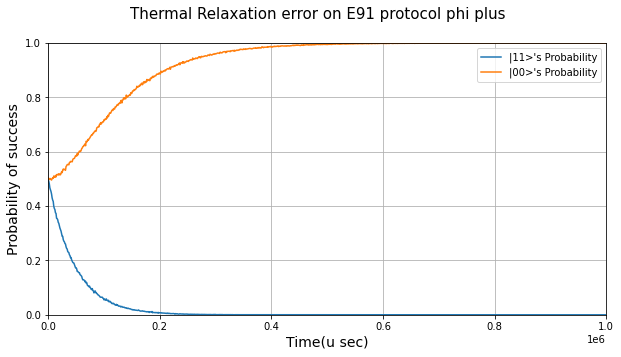

<Figure size 576x360 with 0 Axes>

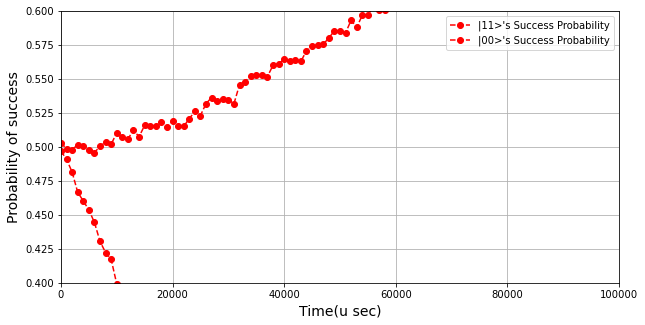

<Figure size 576x360 with 0 Axes>

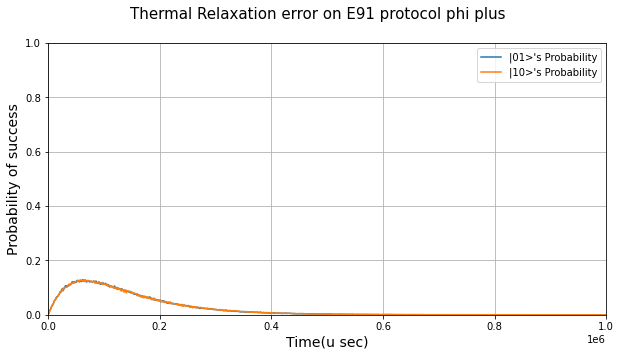

<Figure size 576x360 with 0 Axes>

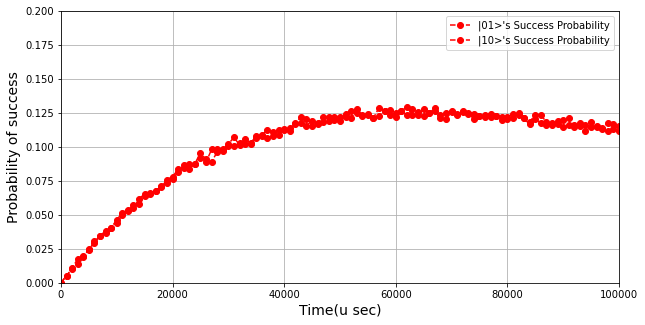

<Figure size 576x360 with 0 Axes>

In [74]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol phi plus',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, d11, label = "|11>'s Probability")
ax.plot(x2, d00, label = "|00>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 100000)
ax.set_ylim(0.4,0.6)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,d11,'ro--',label = "|11>'s Success Probability")
ax.plot(delay,d00,'ro--',label = "|00>'s Success Probability")

ax.legend()

##########################################################################
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol phi plus',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, d01, label = "|01>'s Probability")
ax.plot(x2, d10, label = "|10>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 100000)
ax.set_ylim(0,0.2)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,d01,'ro--',label = "|01>'s Success Probability")
ax.plot(delay,d10,'ro--',label = "|10>'s Success Probability")

ax.legend()

# |01>+|10>

In [75]:
import matplotlib.pyplot as plt
success_state00=[]
success_state11=[]
success_state01=[]
success_state10=[]
for x in range(20): #loop for 20 times average
    delay = np.arange(0,1001000,1000)
    channel = '2'
    apply_error = {"delay":True, "measure": False, "gate": False}
    success11=[]
    success00=[]
    success01=[]
    success10=[]
    
    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success00.append(prob[0])
        success11.append(prob[1])
        success10.append(prob[2])
        success01.append(prob[3])
    success_state00.append(success00)
    success_state11.append(success11)
    success_state01.append(success01)
    success_state10.append(success10) 

In [76]:
import numpy as np
delay = np.arange(0,1001000,1000)


In [77]:
from statistics import mean
a= success_state00
print(*map(mean, zip(*a)))

0.0 0.01065 0.0208 0.03365 0.04005 0.0538 0.0632 0.0732 0.08105 0.09055 0.10325 0.1119 0.11955 0.1271 0.13575 0.1486 0.1584 0.1666 0.1722 0.18215 0.1927 0.20355 0.2117 0.2152 0.2241 0.23535 0.24105 0.2547 0.25625000000000003 0.27475 0.27345 0.28575 0.2913 0.30175 0.31515 0.3124 0.3171 0.32795 0.3363 0.34305 0.35255 0.3594 0.36425 0.3701 0.3711 0.3809 0.3905 0.39740000000000003 0.4032 0.4078 0.417 0.42155 0.42685 0.4353 0.44165 0.44215 0.44830000000000003 0.45205 0.463 0.47365 0.4758 0.484 0.489 0.4894 0.5003 0.50295 0.5075000000000001 0.51305 0.5172 0.5225500000000001 0.524 0.5366500000000001 0.5389 0.55045 0.5435 0.5536 0.5588 0.55695 0.5692 0.5686 0.5749 0.5737 0.5817 0.59105 0.5933499999999999 0.5972999999999999 0.5984499999999999 0.6082 0.6001 0.6059 0.6177 0.62185 0.62625 0.6239 0.6293 0.633 0.64 0.64095 0.64525 0.6528 0.6593 0.6605500000000001 0.6646000000000001 0.6674 0.67155 0.6766 0.67965 0.6798000000000001 0.68245 0.6920999999999999 0.695 0.6971999999999999 0.70285 0.70395 0.

In [78]:
from statistics import mean
a= success_state11
print(*map(mean, zip(*a)))

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

In [79]:
from statistics import mean
a= success_state01
print(*map(mean, zip(*a)))

0.50295 0.4955 0.4884 0.48175 0.4767 0.47065 0.47195 0.4659 0.46005 0.45355 0.44385 0.4433 0.44145 0.4392 0.43069999999999997 0.428 0.42475 0.41545 0.4107 0.40345 0.3996 0.39465 0.3958 0.3871 0.38975 0.3846 0.3803 0.3714 0.3752 0.3686 0.36445 0.35655 0.357 0.35025 0.3409 0.34654999999999997 0.34195 0.33755 0.32915 0.3338 0.3224 0.3143 0.32145 0.3142 0.3187 0.31405 0.30165 0.3031 0.3004 0.3019 0.29075 0.2885 0.2818 0.2773 0.2812 0.27955 0.2774 0.2751 0.2673 0.2643 0.2668 0.2596 0.2544 0.2547 0.25025000000000003 0.25425 0.2475 0.2452 0.24265 0.23905 0.23565 0.23424999999999999 0.2282 0.2281 0.22769999999999999 0.22190000000000001 0.2223 0.21955 0.21615 0.2158 0.21085 0.2118 0.21315 0.2021 0.2013 0.2036 0.1977 0.197 0.2012 0.1971 0.19145 0.19005 0.1858 0.18545 0.1861 0.1833 0.18285 0.18075 0.17645 0.17685 0.16965 0.169 0.16765 0.1661 0.16620000000000001 0.16225 0.1627 0.15795 0.1572 0.15255 0.15335 0.1547 0.14645 0.1485 0.1494 0.1449 0.1407 0.1425 0.14504999999999998 0.1376 0.14165 0.1392

In [80]:
from statistics import mean
a= success_state10
print(*map(mean, zip(*a)))

0.49705 0.49385 0.4908 0.4846 0.48325 0.47555 0.46485 0.4609 0.4589 0.4559 0.4529 0.44480000000000003 0.439 0.4337 0.43355 0.4234 0.41685 0.41795 0.41709999999999997 0.4144 0.4077 0.4018 0.3925 0.3977 0.38615 0.38005 0.37865 0.3739 0.36855 0.35664999999999997 0.3621 0.3577 0.3517 0.348 0.34395 0.34105 0.34095 0.3345 0.33455 0.32315 0.32505 0.32630000000000003 0.3143 0.3157 0.3102 0.30505 0.30785 0.2995 0.2964 0.2903 0.29225 0.28995 0.29135 0.2874 0.27715 0.2783 0.2743 0.27285 0.2697 0.26205 0.2574 0.2564 0.2566 0.2559 0.24945 0.2428 0.245 0.24175 0.24015 0.2384 0.24035 0.2291 0.2329 0.22145 0.2288 0.2245 0.2189 0.2235 0.21465 0.2156 0.21425 0.2145 0.20515 0.20685 0.20535 0.1991 0.20385 0.1948 0.1987 0.197 0.19085 0.1881 0.18795 0.19065000000000001 0.1846 0.1837 0.17715 0.1783 0.1783 0.17035 0.17105 0.17045 0.16775 0.1665 0.16225 0.16115 0.15765 0.16225 0.16035 0.15535 0.15165 0.1481 0.1507 0.14755000000000001 0.1462 0.1404 0.14445 0.14035 0.14115 0.1384 0.13825 0.137 0.1396 0.1375 0.12

In [81]:
# 20 Times Average 
d00=[0.0,0.01065,0.0208,0.03365,0.04005,0.0538,0.0632,0.0732,0.08105,0.09055,0.10325,0.1119,0.11955,0.1271,0.13575,0.1486,0.1584,0.1666,0.1722,0.18215,0.1927,0.20355,0.2117,0.2152,0.2241,0.23535,0.24105,0.2547,0.25625000000000003,0.27475,0.27345,0.28575,0.2913,0.30175,0.31515,0.3124,0.3171,0.32795,0.3363,0.34305,0.35255,0.3594,0.36425,0.3701,0.3711,0.3809,0.3905,0.39740000000000003,0.4032,0.4078,0.417,0.42155,0.42685,0.4353,0.44165,0.44215,0.44830000000000003,0.45205,0.463,0.47365,0.4758,0.484,0.489,0.4894,0.5003,0.50295,0.5075000000000001,0.51305,0.5172,0.5225500000000001,0.524,0.5366500000000001,0.5389,0.55045,0.5435,0.5536,0.5588,0.55695,0.5692,0.5686,0.5749,0.5737,0.5817,0.59105,0.5933499999999999,0.5972999999999999,0.5984499999999999,0.6082,0.6001,0.6059,0.6177,0.62185,0.62625,0.6239,0.6293,0.633,0.64,0.64095,0.64525,0.6528,0.6593,0.6605500000000001,0.6646000000000001,0.6674,0.67155,0.6766,0.67965,0.6798000000000001,0.68245,0.6920999999999999,0.695,0.6971999999999999,0.70285,0.70395,0.7043999999999999,0.7147,0.71485,0.71715,0.7138,0.724,0.7201,0.7238,0.7276,0.72785,0.74005,0.7363,0.74285,0.75025,0.7452,0.74995,0.742,0.75035,0.7551,0.7585500000000001,0.76115,0.7685500000000001,0.76235,0.7664,0.76705,0.767,0.7794,0.77925,0.7866000000000001,0.78495,0.7907000000000001,0.7897500000000001,0.7884,0.7955,0.79405,0.7971,0.7981,0.8074,0.80035,0.80335,0.8027,0.80915,0.80925,0.8125,0.81455,0.8194,0.81915,0.81975,0.8216,0.8252499999999999,0.8303999999999999,0.82985,0.8309,0.8353499999999999,0.8337,0.83775,0.8421,0.8419,0.8393499999999999,0.8402499999999999,0.8442999999999999,0.84455,0.85175,0.8483999999999999,0.85475,0.85165,0.85325,0.85485,0.8583,0.8564499999999999,0.8584499999999999,0.85965,0.8609,0.86455,0.8667,0.8681,0.87285,0.87745,0.87215,0.8764,0.87245,0.8766,0.8752,0.8788,0.8815,0.88135,0.88415,0.88485,0.88735,0.8898,0.8872,0.8865000000000001,0.89235,0.8905500000000001,0.891,0.8952,0.89485,0.8941,0.90005,0.89875,0.9002,0.9026500000000001,0.899,0.9036500000000001,0.9028,0.9072,0.9023,0.9057000000000001,0.9061,0.90615,0.9088,0.91345,0.91,0.9133,0.9132,0.91445,0.9179,0.9182,0.9141,0.91515,0.9179,0.9179,0.91705,0.9205000000000001,0.92205,0.9218000000000001,0.9241,0.9228500000000001,0.92545,0.92495,0.92835,0.9268500000000001,0.92815,0.9296500000000001,0.93475,0.92895,0.93,0.9291,0.9299000000000001,0.9362,0.93505,0.9328000000000001,0.9322,0.93535,0.93785,0.93875,0.94025,0.9368,0.9409,0.9405,0.9406,0.94335,0.9423499999999999,0.9431499999999999,0.9463499999999999,0.94565,0.9426,0.9433,0.947,0.9451999999999999,0.9474,0.94995,0.94875,0.9512499999999999,0.9501,0.9474,0.94885,0.95055,0.9502499999999999,0.95265,0.95175,0.9546,0.9521499999999999,0.9551999999999999,0.9538,0.9544999999999999,0.9552999999999999,0.9571999999999999,0.9568,0.95685,0.9567,0.9573499999999999,0.9573999999999999,0.9595,0.9594499999999999,0.9595,0.9597,0.9606,0.9601999999999999,0.96085,0.961,0.9606,0.9617,0.96355,0.9632999999999999,0.96365,0.9643499999999999,0.96315,0.9641,0.9652499999999999,0.9663999999999999,0.9662,0.9652499999999999,0.9666,0.969,0.9686,0.9668,0.96655,0.96695,0.96955,0.96915,0.9702999999999999,0.9692,0.9684499999999999,0.972,0.971,0.97155,0.9714499999999999,0.9704499999999999,0.9711,0.97225,0.97375,0.97265,0.9744999999999999,0.9718,0.97375,0.9741,0.9723499999999999,0.9735,0.97385,0.9761,0.9744499999999999,0.9761,0.97515,0.97795,0.97515,0.97575,0.9767,0.9776,0.97805,0.97675,0.9782,0.9763499999999999,0.979,0.9788,0.97865,0.97895,0.9791,0.9793499999999999,0.9789,0.9803499999999999,0.9799,0.9803999999999999,0.9798,0.97965,0.981,0.98155,0.98255,0.9815,0.98075,0.98225,0.98195,0.98235,0.98235,0.98215,0.9824999999999999,0.98125,0.98355,0.9822,0.9831,0.98355,0.9828,0.98335,0.98355,0.98475,0.9818,0.9842,0.98415,0.985,0.9836,0.98455,0.98585,0.98585,0.9859,0.98695,0.9871,0.9858,0.9881,0.9859,0.98695,0.98615,0.98535,0.9876,0.98715,0.98775,0.9889,0.9886,0.98775,0.9897,0.98705,0.98695,0.98735,0.98695,0.9888,0.9887,0.98795,0.9886,0.9875,0.9881,0.98955,0.989,0.9894499999999999,0.9896,0.9893,0.9908,0.99015,0.99035,0.9906,0.9903,0.9897,0.9903,0.99085,0.99105,0.9913,0.99235,0.99085,0.9897,0.99055,0.99035,0.99135,0.9913,0.99075,0.99235,0.99075,0.9915,0.99235,0.9914,0.99285,0.99165,0.99225,0.99225,0.9932,0.99195,0.9923,0.99335,0.9922,0.9924999999999999,0.9926,0.9932,0.99195,0.99315,0.99235,0.9934,0.9941,0.9941,0.99305,0.99325,0.99305,0.99335,0.9942,0.9941,0.993,0.9939,0.9935,0.9937,0.9939,0.9937,0.9952,0.99375,0.99475,0.99375,0.9951,0.99425,0.9947,0.9947,0.99435,0.9948,0.9949,0.9955,0.9951,0.99505,0.995,0.99465,0.9956,0.9944,0.9948,0.9956,0.99595,0.9953,0.99495,0.9953,0.9958,0.99565,0.996,0.99565,0.99535,0.9953,0.9949,0.99565,0.99555,0.99565,0.99635,0.9958,0.9958,0.9972,0.9961,0.9953,0.996,0.99625,0.997,0.9962,0.9969,0.99615,0.99645,0.9962,0.99685,0.99635,0.9967,0.9963,0.99655,0.9968,0.9968,0.99695,0.9964,0.997,0.99665,0.99695,0.99665,0.99725,0.99665,0.9975,0.9974,0.9973,0.9973,0.99715,0.9977,0.9969,0.99705,0.9976,0.99725,0.99725,0.9976,0.9981,0.99795,0.99775,0.99715,0.9975,0.99735,0.99805,0.99725,0.9969,0.99765,0.9979,0.99795,0.99775,0.99735,0.9979,0.9978,0.9983,0.99775,0.9977,0.99755,0.9976,0.9976,0.9979,0.998,0.9977,0.9974,0.9979,0.9974,0.9986,0.99865,0.9979,0.9977,0.99835,0.9983,0.99805,0.99855,0.9984999999999999,0.99815,0.99805,0.99775,0.99875,0.9984,0.9982,0.99875,0.99815,0.9986,0.9984999999999999,0.9986,0.9989,0.9992,0.9988,0.9982,0.9983,0.9989,0.99885,0.9989,0.99835,0.9984,0.99835,0.9986,0.99845,0.9987,0.99855,0.99835,0.9987,0.999,0.99875,0.9992,0.9988,0.99875,0.99865,0.9987,0.99875,0.99865,0.9988,0.9987,0.99945,0.9989,0.99855,0.999,0.99895,0.999,0.99905,0.9989,0.9988,0.999,0.9989,0.999,0.9989,0.9991,0.9991,0.99895,0.99905,0.9991,0.9988,0.99885,0.999,0.99915,0.9993,0.9993,0.999,0.99905,0.99935,0.9988,0.9989,0.99925,0.9989,0.9991,0.999,0.9993,0.9995,0.99945,0.9993,0.99925,0.9993,0.9993,0.9995,0.9994,0.9991,0.9995,0.9996,0.9993,0.99935,0.99905,0.99935,0.99945,0.99975,0.9991,0.9994,0.9993,0.9991,0.99955,0.9994,0.99935,0.9993,0.99915,0.99955,0.99955,0.99925,0.9991,0.99925,0.99945,0.9997,0.9994,0.9998,0.9995,0.99975,0.9994,0.99945,0.99965,0.9996,0.9993,0.9995,0.99955,0.9994,0.9994,0.9994,0.99965,0.9994,0.99965,0.9995,0.9995,0.9993,0.99965,0.9994,0.9996,0.99935,0.99965,0.99955,0.9995,0.9996,0.9996,0.9994,0.99945,0.99935,0.9997,0.9996,0.99965,0.99985,0.99985,0.9998,0.9999,0.9998,0.99965,0.9996,0.99965,0.99935,0.99955,0.9996,0.9997,0.99965,0.9996,0.9996,0.99975,0.9999,0.9996,0.9997,0.99975,0.9996,0.9997,0.9997,0.9997,0.9998,0.99965,0.9995,0.9996,0.99955,0.9998,0.9997,0.9998,0.99965,0.99975,0.99975,0.99955,0.99985,0.99975,0.9998,0.99975,0.9999,0.9997,0.99995,0.99965,0.99955,0.9997,0.9996,0.9998,0.99985,0.9999,0.99975,0.99985,0.99975,0.9999,0.9998,0.99985,0.99975,0.9999,0.99985,0.99985,0.9997,0.99985,0.9997,0.99985,0.9999,0.9998,0.9999,0.9999,0.99975,1.0,0.9998,0.9998,0.9998,0.9998,0.99985,0.99985,0.9997,0.99985,0.99975,0.9995,0.9999,0.99985,0.99995,0.99985,0.99995,0.99975,0.9998,0.9999,0.9999,0.99995,0.99985,0.99985,0.99975,0.99985,0.9999,0.99985,0.99985,0.99995,0.9997,0.99985,0.9999,0.99985,0.9999,0.99995,0.9999,0.9999,0.99985,0.9999,0.99985,0.9998,0.9999,0.99995,0.9999,0.9999,0.9999,0.99985,1.0,1.0,0.9999,0.99995,0.99975,0.99985,0.99995,0.9999,0.9999,0.99995,0.99995,0.9999,0.99985,0.9999,0.99995,0.99995,0.99995,0.9998,0.99985,0.99985,0.9999,0.99995,0.99995,0.9999,0.9998,0.9999,0.9998,0.99995,0.99995,0.9998,0.9999,0.9999,0.9999,1.0,0.9999,1.0,0.99985,0.99985,0.99995,0.99995,0.9999,0.9998,0.9999,0.99995,0.9999,0.99995,1.0,0.99995,0.9999,0.9999,0.99995,0.99995,0.99995,1.0,0.99995,0.99995,0.99985,0.99995,0.99995,1.0,1.0,1.0,0.99985,0.99995,0.99985,0.9999,0.99995,0.9999,0.9999,1.0,1.0,0.99985,0.99995,1.0,0.99995,0.99995,0.99995,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,0.99995,0.99995,1.0,0.9998,0.99995,1.0,0.99995,1.0,1.0,0.99995,0.9999,1.0,1.0,0.99995,0.99995,0.99995,1.0,1.0,0.9999,1.0,0.99995,1.0,1.0,1.0,1.0,0.99995,1.0,0.99995,0.99995,0.99995,0.9999,1.0,1.0,0.99995,1.0,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,0.99995,0.9999,0.9999,0.99995,1.0,1.0,1.0,1.0,0.99985,1.0,1.0,1.0,0.99995,1.0,1.0,1.0,1.0,0.99995,0.99995,0.9999,1.0]


In [84]:
d11=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]


In [83]:
d01=[0.50295,0.4955,0.4884,0.48175,0.4767,0.47065,0.47195,0.4659,0.46005,0.45355,0.44385,0.4433,0.44145,0.4392,0.43069999999999997,0.428,0.42475,0.41545,0.4107,0.40345,0.3996,0.39465,0.3958,0.3871,0.38975,0.3846,0.3803,0.3714,0.3752,0.3686,0.36445,0.35655,0.357,0.35025,0.3409,0.34654999999999997,0.34195,0.33755,0.32915,0.3338,0.3224,0.3143,0.32145,0.3142,0.3187,0.31405,0.30165,0.3031,0.3004,0.3019,0.29075,0.2885,0.2818,0.2773,0.2812,0.27955,0.2774,0.2751,0.2673,0.2643,0.2668,0.2596,0.2544,0.2547,0.25025000000000003,0.25425,0.2475,0.2452,0.24265,0.23905,0.23565,0.23424999999999999,0.2282,0.2281,0.22769999999999999,0.22190000000000001,0.2223,0.21955,0.21615,0.2158,0.21085,0.2118,0.21315,0.2021,0.2013,0.2036,0.1977,0.197,0.2012,0.1971,0.19145,0.19005,0.1858,0.18545,0.1861,0.1833,0.18285,0.18075,0.17645,0.17685,0.16965,0.169,0.16765,0.1661,0.16620000000000001,0.16225,0.1627,0.15795,0.1572,0.15255,0.15335,0.1547,0.14645,0.1485,0.1494,0.1449,0.1407,0.1425,0.14504999999999998,0.1376,0.14165,0.1392,0.1328,0.13465,0.13275,0.13195,0.12805,0.12625,0.12285,0.124,0.1286,0.1261,0.12415,0.12075,0.1194,0.11515,0.11845,0.11535000000000001,0.11465,0.11955,0.1104,0.11165,0.1076,0.10880000000000001,0.1038,0.10745,0.10465,0.1025,0.10335,0.10275,0.1001,0.0979,0.09845,0.0997,0.10165,0.09405,0.0955,0.09565,0.09105,0.08765,0.0889,0.09225,0.08845,0.08435,0.08375,0.0835,0.08600000000000001,0.08365,0.0843,0.0801,0.07805,0.07835,0.0802,0.0807,0.0755,0.0789,0.0732,0.07455,0.07435,0.07475,0.07275,0.07314999999999999,0.0702,0.0738,0.07145,0.0702,0.0704,0.06645,0.06635,0.0651,0.0647,0.0629,0.0639,0.06325,0.0627,0.061900000000000004,0.06045,0.06055,0.05815,0.0597,0.05995,0.05775,0.05725,0.0548,0.05625,0.0543,0.0506,0.05545,0.05495,0.0535,0.05435,0.05215,0.05095,0.05155,0.051449999999999996,0.04785,0.0527,0.04845,0.0494,0.04535,0.0491,0.04585,0.0464,0.04725,0.0457,0.042,0.043,0.04325,0.04205,0.0411,0.04095,0.04095,0.042,0.0432,0.0386,0.0425,0.04295,0.0399,0.03805,0.041,0.03895,0.0404,0.0354,0.0373,0.03595,0.03725,0.0353,0.03625,0.03415,0.03565,0.0343,0.036,0.03465,0.0311,0.03385,0.0334,0.0334,0.03255,0.0316,0.03195,0.02895,0.0327,0.02795,0.0286,0.0309,0.02805,0.02975,0.0293,0.0264,0.02735,0.0285,0.0297,0.027200000000000002,0.0258,0.02635,0.02425,0.0273,0.02365,0.0253,0.02545,0.0248,0.0247,0.0244,0.024,0.02385,0.0224,0.02425,0.02195,0.02375,0.023,0.0215,0.020900000000000002,0.02075,0.021849999999999998,0.02165,0.022350000000000002,0.02245,0.01945,0.0225,0.0201,0.0206,0.0197,0.0193,0.02035,0.02015,0.02,0.0197,0.0178,0.0189,0.0189,0.0176,0.019,0.01735,0.0179,0.0171,0.01685,0.0164,0.01565,0.01645,0.01515,0.01715,0.01685,0.0173,0.0141,0.01465,0.01505,0.0151,0.0161,0.01465,0.0133,0.01405,0.0143,0.0149,0.0132,0.0137,0.0131,0.01345,0.01265,0.01365,0.01315,0.01275,0.01565,0.01185,0.013,0.01235,0.01125,0.013049999999999999,0.011899999999999999,0.01075,0.0124,0.01225,0.01215,0.01095,0.011649999999999999,0.0109,0.0113,0.0127,0.0105,0.0105,0.01015,0.0098,0.01035,0.01,0.01005,0.0095,0.0093,0.0094,0.00975,0.0109,0.00995,0.0084,0.00885,0.00915,0.00935,0.0087,0.009,0.0087,0.0084,0.0092,0.00935,0.00935,0.00795,0.00925,0.0086,0.0079,0.0088,0.0082,0.00835,0.0078,0.00925,0.00775,0.00825,0.007,0.008749999999999999,0.00765,0.00765,0.0073,0.0072,0.00665,0.00685,0.00785,0.0053,0.0075,0.0059499999999999996,0.00655,0.00705,0.00615,0.007,0.00665,0.00595,0.00575,0.0059,0.00495,0.0066,0.00685,0.0065,0.00655,0.0055,0.0051,0.0055,0.0057,0.00665,0.00545,0.0064,0.0051,0.00515,0.00595,0.00535,0.00475,0.00475,0.00495,0.0045000000000000005,0.0051,0.00485,0.0053,0.0045000000000000005,0.0046500000000000005,0.0043,0.00425,0.00465,0.0053,0.0048000000000000004,0.0048000000000000004,0.0037,0.0039000000000000003,0.0046500000000000005,0.00335,0.00435,0.0042,0.00375,0.00455,0.0039000000000000003,0.0039000000000000003,0.0039000000000000003,0.00415,0.00305,0.0042,0.0038,0.00345,0.0038,0.00395,0.00355,0.00295,0.00395,0.0035,0.00405,0.0041,0.0029000000000000002,0.0032,0.00295,0.00395,0.00365,0.0032,0.00265,0.00295,0.0035,0.00355,0.00365,0.0034000000000000002,0.00295,0.00275,0.00275,0.0034000000000000002,0.00255,0.003,0.00235,0.00275,0.003,0.00265,0.0031,0.00255,0.0029000000000000002,0.0021,0.0022500000000000003,0.0028,0.00265,0.00245,0.00285,0.00255,0.0023,0.0022500000000000003,0.002,0.00245,0.00235,0.0026,0.00205,0.00215,0.0022,0.002,0.00265,0.002,0.0027,0.00205,0.0027,0.0023,0.00215,0.00205,0.00205,0.0014,0.0019,0.00245,0.0019,0.0016,0.0017000000000000001,0.00215,0.00205,0.0019,0.0017000000000000001,0.00205,0.00165,0.00165,0.00175,0.00175,0.00155,0.0015,0.0015,0.0016,0.0014,0.0016,0.00135,0.00185,0.0018,0.0012000000000000001,0.00175,0.0013,0.0014,0.0011,0.00165,0.0015,0.0013,0.0015,0.0014500000000000001,0.00105,0.00155,0.00155,0.00105,0.00065,0.00075,0.001,0.0012000000000000001,0.00135,0.0012000000000000001,0.00095,0.00135,0.0015,0.00135,0.00105,0.0009,0.0011,0.0013,0.00115,0.0011,0.0008500000000000001,0.0008500000000000001,0.00125,0.0011,0.00135,0.00115,0.0013,0.00105,0.0015,0.0012000000000000001,0.0008500000000000001,0.0013,0.0007,0.0008,0.0011,0.001,0.001,0.0008500000000000001,0.0009,0.0008500000000000001,0.0007,0.00105,0.00125,0.0011,0.0007,0.0007,0.00055,0.0008,0.001,0.00065,0.0006000000000000001,0.00065,0.00075,0.00025,0.00045,0.0008,0.00105,0.0008,0.00045,0.00055,0.00065,0.00065,0.0008500000000000001,0.0008,0.00045,0.00065,0.00065,0.0007,0.0006000000000000001,0.00055,0.00065,0.00045,0.0005,0.00055,0.0006000000000000001,0.00055,0.0005,0.00045,0.0004,0.0006000000000000001,0.00030000000000000003,0.0004,0.00055,0.0006000000000000001,0.00030000000000000003,0.00045,0.0005,0.0005,0.00075,0.0005,0.00065,0.0004,0.00055,0.0007,0.00045,0.0006000000000000001,0.00035,0.00045,0.00075,0.00065,0.00055,0.00045,0.0005,0.0002,0.00055,0.00035,0.00030000000000000003,0.0004,0.00065,0.00045,0.00030000000000000003,0.00045,0.00055,0.00035,0.00025,0.0001,0.0004,0.0005,0.0004,0.00030000000000000003,0.00035,0.00025,0.0007,0.00025,0.0001,0.00015000000000000001,0.00030000000000000003,0.00045,0.00045,0.0002,0.0001,0.00045,0.00030000000000000003,0.00045,0.0004,0.0002,0.0004,0.0004,0.0004,0.00035,0.00030000000000000003,0.00015000000000000001,0.00035,0.0006000000000000001,0.0002,0.00035,5e-05,0.00025,5e-05,0.00025,5e-05,0.00030000000000000003,0.00035,0.00025,0.00015000000000000001,0.00045,0.0002,0.0002,0.00030000000000000003,0.00030000000000000003,0.0002,0.00015000000000000001,0.00035,0.00030000000000000003,0.0004,0.0001,0.0004,0.0001,0.00025,5e-05,0.00045,0.00015000000000000001,0.0002,0.0002,0.00015000000000000001,0.0002,0.00030000000000000003,0.00035,0.00035,0.00015000000000000001,0.0002,0.00015000000000000001,5e-05,0.0001,5e-05,0.0,0.0,0.00025,0.00025,0.00030000000000000003,0.00025,0.0002,0.00015000000000000001,5e-05,0.00015000000000000001,0.0001,0.00015000000000000001,0.0002,5e-05,0.0002,0.00025,0.0001,0.00015000000000000001,0.00015000000000000001,0.0002,5e-05,5e-05,0.0001,0.00035,0.00015000000000000001,0.00030000000000000003,5e-05,5e-05,0.0001,5e-05,0.00015000000000000001,0.0002,0.00035,0.0001,0.0001,0.0002,0.0002,5e-05,5e-05,5e-05,0.0,0.00030000000000000003,0.00015000000000000001,5e-05,5e-05,5e-05,5e-05,0.00025,0.0001,5e-05,0.0001,0.00015000000000000001,0.0001,0.0002,0.0,0.0001,0.00015000000000000001,0.00015000000000000001,0.0,0.00015000000000000001,0.0,5e-05,0.0001,5e-05,0.0001,0.0001,0.0,0.0001,0.0,0.0001,0.00015000000000000001,5e-05,5e-05,5e-05,5e-05,0.00015000000000000001,0.0004,0.0001,0.0001,5e-05,0.0001,5e-05,0.00015000000000000001,0.0001,5e-05,5e-05,5e-05,5e-05,0.0001,0.0001,5e-05,0.0,5e-05,0.0,0.0,0.00025,5e-05,0.0,0.0,5e-05,5e-05,0.0001,5e-05,5e-05,5e-05,5e-05,0.0001,5e-05,0.0,0.0001,5e-05,0.0,0.00015000000000000001,0.0,0.0,0.0001,0.0,0.0001,5e-05,0.0,5e-05,5e-05,5e-05,0.0,5e-05,5e-05,5e-05,0.0,0.0,0.0,0.00015000000000000001,0.0001,0.0001,0.0001,5e-05,0.0,5e-05,0.0001,5e-05,0.0001,5e-05,0.0,0.00015000000000000001,0.0001,0.0,0.0,0.0,5e-05,0.0,0.0001,5e-05,5e-05,0.0,0.0001,5e-05,5e-05,0.0,5e-05,0.0,0.0,5e-05,0.0001,5e-05,0.0,5e-05,0.0,0.0,5e-05,0.0,0.00015000000000000001,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0001,0.0001,5e-05,0.0,0.0001,0.0,0.0,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0001,0.0,0.0,5e-05,0.0,0.0,0.0,0.0001,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,5e-05,5e-05,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,0.0]


In [82]:
d10=[0.49705,0.49385,0.4908,0.4846,0.48325,0.47555,0.46485,0.4609,0.4589,0.4559,0.4529,0.44480000000000003,0.439,0.4337,0.43355,0.4234,0.41685,0.41795,0.41709999999999997,0.4144,0.4077,0.4018,0.3925,0.3977,0.38615,0.38005,0.37865,0.3739,0.36855,0.35664999999999997,0.3621,0.3577,0.3517,0.348,0.34395,0.34105,0.34095,0.3345,0.33455,0.32315,0.32505,0.32630000000000003,0.3143,0.3157,0.3102,0.30505,0.30785,0.2995,0.2964,0.2903,0.29225,0.28995,0.29135,0.2874,0.27715,0.2783,0.2743,0.27285,0.2697,0.26205,0.2574,0.2564,0.2566,0.2559,0.24945,0.2428,0.245,0.24175,0.24015,0.2384,0.24035,0.2291,0.2329,0.22145,0.2288,0.2245,0.2189,0.2235,0.21465,0.2156,0.21425,0.2145,0.20515,0.20685,0.20535,0.1991,0.20385,0.1948,0.1987,0.197,0.19085,0.1881,0.18795,0.19065000000000001,0.1846,0.1837,0.17715,0.1783,0.1783,0.17035,0.17105,0.17045,0.16775,0.1665,0.16225,0.16115,0.15765,0.16225,0.16035,0.15535,0.15165,0.1481,0.1507,0.14755000000000001,0.1462,0.1404,0.14445,0.14035,0.14115,0.1384,0.13825,0.137,0.1396,0.1375,0.1272,0.13175,0.1291,0.1235,0.13195,0.12605,0.12940000000000002,0.12355,0.12075,0.1207,0.11945,0.1163,0.1192,0.11825,0.1183,0.11345,0.1102,0.1091,0.1058,0.10625,0.1055,0.1028,0.10695,0.102,0.1026,0.10015,0.1018,0.0947,0.1012,0.09695,0.09565,0.0968,0.09525,0.09185,0.0944,0.09295,0.09195,0.088,0.08995,0.0904,0.08585,0.08665,0.0831,0.081,0.082,0.08215,0.07985,0.07975,0.08045,0.07905,0.0802,0.07654999999999999,0.07505,0.07705000000000001,0.0709,0.0736,0.074,0.072,0.0715,0.06974999999999999,0.0701,0.07015,0.0687,0.069,0.06695,0.0668,0.06245,0.05965,0.06395,0.06035,0.06485,0.0615,0.06435,0.06065,0.06035,0.05895,0.0559,0.0574,0.0554,0.0554,0.056549999999999996,0.0592,0.057050000000000003,0.054,0.05405,0.0513,0.0508,0.05375,0.049,0.0497,0.04835,0.0495,0.0483,0.0479,0.0478,0.04745,0.0486,0.04845,0.0475,0.0466,0.0455,0.04455,0.047,0.04345,0.04475,0.04445,0.04115,0.04085,0.0439,0.04165,0.043500000000000004,0.039599999999999996,0.04,0.0396,0.0399,0.0372,0.03695,0.03675,0.03915,0.03775,0.0357,0.0359,0.03655,0.0341,0.0311,0.0354,0.0357,0.0349,0.03545,0.0327,0.0311,0.0338,0.0344,0.032100000000000004,0.03055,0.0293,0.0308,0.0305,0.03115,0.0309,0.0285,0.0286,0.0279,0.02755,0.02725,0.027,0.0289,0.027,0.0258,0.029,0.02625,0.0258,0.02395,0.0251,0.0246,0.02715,0.02635,0.02475,0.02535,0.02335,0.0244,0.023,0.0236,0.02285,0.02245,0.0225,0.0232,0.0219,0.02245,0.0213,0.02165,0.0203,0.02015,0.02105,0.01805,0.0204,0.0197,0.0197,0.0205,0.0188,0.01885,0.0194,0.0186,0.01865,0.0178,0.01745,0.01805,0.01785,0.01855,0.01685,0.0165,0.01695,0.018349999999999998,0.01775,0.01455,0.01625,0.016050000000000002,0.0166,0.01575,0.01635,0.0162,0.01465,0.0157,0.01545,0.01335,0.0157,0.0144,0.01425,0.01465,0.0157,0.01405,0.01315,0.0139,0.01285,0.01455,0.0131,0.01315,0.012,0.01465,0.01315,0.01155,0.0143,0.01085,0.01295,0.0113,0.01245,0.012,0.01115,0.01145,0.0103,0.01235,0.0105,0.01095,0.0105,0.0107,0.0112,0.01125,0.01055,0.01065,0.01105,0.01015,0.0108,0.010199999999999999,0.01045,0.00945,0.009049999999999999,0.01005,0.0086,0.00935,0.009899999999999999,0.00905,0.00905,0.00895,0.00925,0.00865,0.00815,0.0094,0.0085,0.00855,0.0083,0.00855,0.0084,0.00845,0.0081,0.00745,0.00895,0.00805,0.0076,0.008,0.00765,0.0078000000000000005,0.0065,0.00685,0.0069,0.0064,0.00605,0.00635,0.0066,0.0066,0.0071,0.0073,0.0076,0.00625,0.00585,0.0056,0.00515,0.0056500000000000005,0.00635,0.00535,0.00635,0.0062,0.00615,0.0065,0.0057,0.0062,0.00655,0.0057,0.00585,0.00645,0.00405,0.0059,0.0054,0.00445,0.00535,0.00445,0.0051,0.0047,0.0049,0.0046,0.00545,0.0044,0.0046500000000000005,0.0043,0.0044,0.0034000000000000002,0.0045000000000000005,0.005,0.00465,0.00485,0.00495,0.0048000000000000004,0.0046,0.0043,0.0049,0.0043,0.0039000000000000003,0.00405,0.0032500000000000003,0.00445,0.00385,0.0036,0.00375,0.00385,0.0039000000000000003,0.0032,0.004,0.00355,0.00385,0.00385,0.0041,0.00335,0.0036,0.0025,0.003,0.0027,0.004,0.0028,0.0033,0.00345,0.00315,0.00295,0.0035,0.00255,0.00285,0.0029000000000000002,0.00315,0.00355,0.00205,0.00285,0.0027,0.0032500000000000003,0.00255,0.003,0.0023,0.00265,0.00255,0.00265,0.0022,0.0024000000000000002,0.00265,0.00215,0.00235,0.0029000000000000002,0.00155,0.00305,0.0029000000000000002,0.00215,0.00205,0.0022500000000000003,0.0027,0.0021,0.00215,0.0022,0.0018,0.00235,0.002,0.0027,0.0024000000000000002,0.0023,0.00175,0.00205,0.0015,0.00215,0.00215,0.0014,0.002,0.0022500000000000003,0.0021,0.00215,0.0013,0.00165,0.00105,0.0019500000000000001,0.00185,0.00175,0.0015,0.002,0.00155,0.0019500000000000001,0.0019,0.0017000000000000001,0.0017000000000000001,0.0014500000000000001,0.0022,0.0014,0.002,0.0012000000000000001,0.00155,0.00155,0.0016,0.0012000000000000001,0.0012000000000000001,0.0016,0.00105,0.00135,0.001,0.0016,0.0015,0.00135,0.0012000000000000001,0.0012000000000000001,0.00135,0.00125,0.0013,0.00125,0.00165,0.00115,0.0014500000000000001,0.001,0.0014,0.0016,0.001,0.00105,0.00115,0.00115,0.00135,0.00095,0.0011,0.0008500000000000001,0.0014,0.00105,0.00135,0.00105,0.00125,0.0008,0.00095,0.0008,0.0014,0.00125,0.0013,0.0007,0.00055,0.001,0.0013,0.00065,0.0008500000000000001,0.00105,0.0006000000000000001,0.0008,0.0008,0.0007,0.00115,0.00055,0.0009,0.00125,0.00045,0.0008500000000000001,0.00075,0.0009,0.00075,0.00035,0.00055,0.00075,0.001,0.00065,0.00030000000000000003,0.0007,0.00055,0.001,0.00095,0.0008,0.0006000000000000001,0.0011,0.00065,0.0008,0.00095,0.0007,0.00045,0.0006000000000000001,0.00035,0.0007,0.0007,0.00075,0.00075,0.00075,0.0009,0.0008,0.0007,0.00025,0.0007,0.0009,0.0004,0.00075,0.00055,0.00045,0.0006000000000000001,0.00045,0.0005,0.00045,0.0006000000000000001,0.00055,0.0002,0.00045,0.00045,0.0006000000000000001,0.00045,0.00045,0.0005,0.00045,0.0004,0.0002,0.0005,0.00045,0.0006000000000000001,0.00035,0.0008,0.00045,0.00030000000000000003,0.0008,0.00045,0.00045,0.00035,0.00025,0.00045,0.00030000000000000003,0.00025,0.00030000000000000003,0.0004,0.00015000000000000001,0.00035,0.0002,0.00025,0.00030000000000000003,0.00055,0.00035,0.0005,0.0002,0.00035,0.00015000000000000001,0.00045,0.00030000000000000003,0.00025,0.0005,0.00025,0.0002,0.00025,0.00030000000000000003,0.0005,0.00015000000000000001,0.00030000000000000003,0.0004,0.00030000000000000003,0.00055,0.0002,0.00025,0.00035,0.00015000000000000001,0.00025,0.0002,0.00030000000000000003,0.0002,0.0001,0.00025,0.00025,0.00030000000000000003,0.00025,0.00030000000000000003,0.00030000000000000003,0.0004,0.0002,0.00025,5e-05,0.0001,0.0004,0.00030000000000000003,0.00025,0.00035,0.00035,0.0002,0.0002,0.00025,0.00030000000000000003,0.00025,0.0002,0.00030000000000000003,0.0002,0.00030000000000000003,0.00015000000000000001,0.0002,0.0002,0.0001,5e-05,0.00015000000000000001,0.0001,0.0002,0.0001,0.00015000000000000001,5e-05,0.0004,0.00025,0.00025,0.00025,0.0002,0.00030000000000000003,0.00025,5e-05,5e-05,0.0002,5e-05,0.00015000000000000001,0.00025,0.00015000000000000001,0.0001,0.00025,0.00015000000000000001,0.00025,0.00015000000000000001,0.00025,0.00015000000000000001,0.00015000000000000001,0.00025,0.0001,0.00030000000000000003,0.0001,5e-05,0.0001,5e-05,0.00015000000000000001,0.0,5e-05,5e-05,0.00025,0.0,0.00035,0.00015000000000000001,0.00015000000000000001,0.00035,0.00015000000000000001,0.0001,5e-05,0.0,5e-05,0.0002,0.0,5e-05,5e-05,5e-05,0.0001,5e-05,0.0,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,0.00015000000000000001,5e-05,0.0001,5e-05,0.0,0.00015000000000000001,0.0,0.0001,0.0002,0.0001,5e-05,0.0001,0.0001,0.00025,0.0001,0.0001,0.0001,0.0,5e-05,0.0,5e-05,0.0,0.0001,0.0001,5e-05,5e-05,0.0,0.0001,5e-05,0.00015000000000000001,0.0001,0.0001,0.0001,0.00015000000000000001,5e-05,5e-05,0.0001,0.0001,0.00015000000000000001,5e-05,0.0,0.0,5e-05,0.0001,5e-05,0.0001,0.0001,5e-05,5e-05,0.0,5e-05,0.0001,0.0,0.0,0.0,0.0,5e-05,0.00015000000000000001,0.0001,5e-05,5e-05,5e-05,0.0,5e-05,5e-05,0.0001,5e-05,5e-05,5e-05,5e-05,5e-05,5e-05,5e-05,0.0,0.0,5e-05,5e-05,0.0001,5e-05,0.0001,0.0,5e-05,5e-05,0.0,0.0001,0.0001,0.0,5e-05,0.0,5e-05,0.0001,0.0,5e-05,0.0,0.00015000000000000001,5e-05,5e-05,5e-05,5e-05,0.0,0.0,0.0,5e-05,5e-05,0.0,5e-05,0.0,0.0,5e-05,0.0,5e-05,5e-05,0.0,0.0,0.0,0.00015000000000000001,0.0,5e-05,0.0,0.0,0.0001,0.0,0.0,0.0,0.0001,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0001,5e-05,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,5e-05,0.0,5e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,5e-05,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0001,0.0,0.0,0.0,5e-05,0.0,0.0,0.0,0.0,5e-05,5e-05,0.0,0.0]


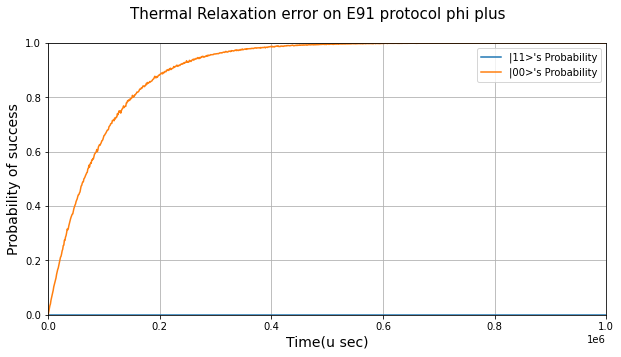

<Figure size 576x360 with 0 Axes>

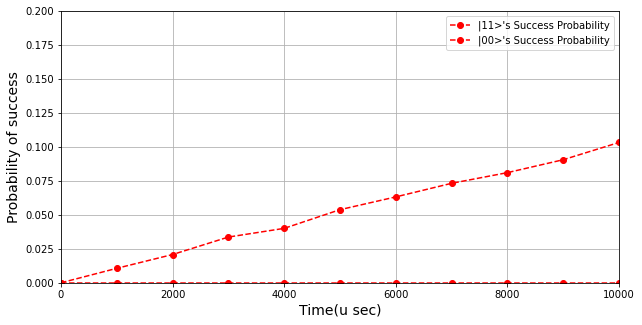

<Figure size 576x360 with 0 Axes>

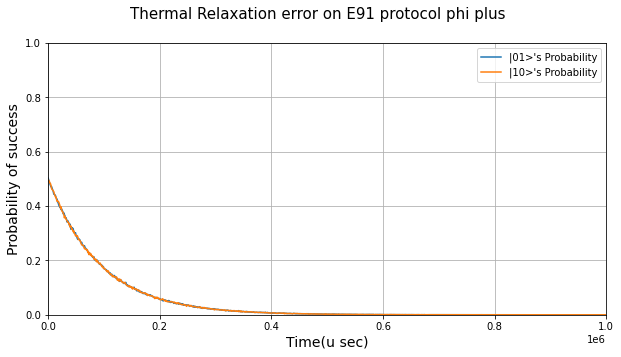

<Figure size 576x360 with 0 Axes>

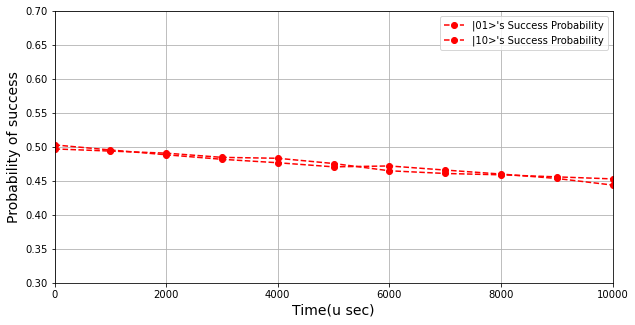

<Figure size 576x360 with 0 Axes>

In [89]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol phi plus',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, d11, label = "|11>'s Probability")
ax.plot(x2, d00, label = "|00>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 10000)
ax.set_ylim(0,0.2)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,d11,'ro--',label = "|11>'s Success Probability")
ax.plot(delay,d00,'ro--',label = "|00>'s Success Probability")

ax.legend()

##########################################################################
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol phi plus',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, d01, label = "|01>'s Probability")
ax.plot(x2, d10, label = "|10>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, 10000)
ax.set_ylim(0.3,0.7)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,d01,'ro--',label = "|01>'s Success Probability")
ax.plot(delay,d10,'ro--',label = "|10>'s Success Probability")

ax.legend()

# Graph Compairing

In [38]:
x1=b
x2=c
x3=d
x4=e
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Phi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,label = "Error on channel length")
ax.plot(delay,x2,label = "Error on channel length+Measure")
ax.plot(delay,x3,label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,label = "Error on channel length+Gate")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,x1,'ro--',label = "Error on channel length")
ax.plot(delay,x2,'ko--',label = "Error on channel length+Measure")
ax.plot(delay,x3,'bo--',label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,'go--',label = "Error on channel length+Gate")
ax.legend()
#################################################################################




NameError: name 'b' is not defined

In [ ]:
x1=b2
x2=c2
x3=d2
x4=e2
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on E91 protocol Psi+',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()

fig = plt.figure(figsize=(8,5))
ax.plot(delay,x1,label = "Error on channel length")
ax.plot(delay,x2,label = "Error on channel length+Measure")
ax.plot(delay,x3,label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,label = "Error on channel length+Gate")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
#fig.suptitle('Thermal Relaxation error on E91 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))

ax.plot(delay,x1,'ro--',label = "Error on channel length")
ax.plot(delay,x2,'ko--',label = "Error on channel length+Measure")
ax.plot(delay,x3,'bo--',label = "Error on channel length+Measure+Gate")
ax.plot(delay,x4,'go--',label = "Error on channel length+Gate")
ax.legend()
#################################################################################

